In [100]:
from PIL import Image
from glob import glob
import pandas as pd
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening, convex_hull_image
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pydicom
import scipy.misc
import numpy as np
import SimpleITK as sitk
import tensorflow as tf
import cv2

In [101]:
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    image_array = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return image_array, origin, spacing

In [102]:
luna_subset_path = '/DATA/jakaria_data/resources/subset0/'
luna_subset_path_mask = '/DATA/jakaria_data/resources/masks/subset0/'
file_list=glob(luna_subset_path+"*.mhd")
file_list_mask=glob(luna_subset_path_mask+"*.mhd")

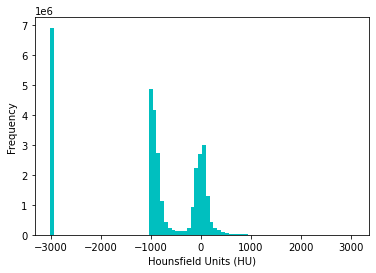

In [103]:
from matplotlib import pyplot as plt

img, origin, spacing = load_itk(file_list[0])
first_patient_pixels = img
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

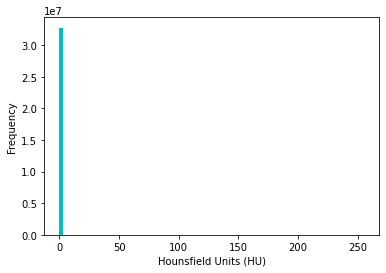

In [104]:
from matplotlib import pyplot as plt

img_mask, origin, spacing = load_itk(file_list_mask[0])
first_patient_pixels = img_mask
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [105]:
def resample(image, previous_spacing, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array(previous_spacing, dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [106]:
img2, spacing2 = resample(img, spacing)
print(img_mask.shape)

(125, 512, 512)


In [107]:
print(img_mask.dtype)

uint8


In [108]:
print(img.shape, spacing)
print(img2.shape, spacing2)
img_mask.shape

(124, 512, 512) [2.5      0.703125 0.703125]
(310, 360, 360) [1. 1. 1.]


(125, 512, 512)

In [109]:
all_imgs = []
def get_segmented_lungs(im, plot=False):
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    plt_number = 0
    # Original image label: 0
    if plot:
        f, plots = plt.subplots(12, 1, figsize=(5, 40))
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1
        img = im.copy()
        all_imgs.append(img)
    # Step 1: Convert into a binary image.
    # image label: 1
    binary = im < -604
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
        all_imgs.append(binary)
    # Step 2: Remove the blobs connected to the border of the image.
    # image label: 2
    cleared = clear_border(binary)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(cleared, cmap=plt.cm.bone)
        plt_number += 1
        all_imgs.append(cleared)
    # Step 3: Label the image.
    # image label: 3
    label_image = label(cleared)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1
        all_imgs.append(label_image)

    # Step 4: Keep the labels with 2 largest areas and segment two lungs.
    # image label: 4
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    labels = []
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
            else:
                coordinates = region.coords[0]
                labels.append(label_image[coordinates[0], coordinates[1]])
    else:
        labels = [1, 2]
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1
        all_imgs.append(label_image)
    # Step 5: Fill in the small holes inside the mask of lungs which we seperate right and left lung. r and l are symbolic and they can be actually left and right!
    # image labels: 5, 6
    r = label_image == labels[0]
    l = label_image == labels[1]
    r_edges = roberts(r)
    l_edges = roberts(l)
    r = ndi.binary_fill_holes(r_edges)
    l = ndi.binary_fill_holes(l_edges)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1
        all_imgs.append(r)

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1
        all_imgs.append(l)

    # Step 6: convex hull of each lung
    # image labels: 7, 8
    r = convex_hull_image(r)
    l = convex_hull_image(l)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1
        all_imgs.append(r)

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1
        all_imgs.append(l)
    # Step 7: joint two separated right and left lungs.
    # image label: 9
    sum_of_lr = r + l
    binary = sum_of_lr > 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
        all_imgs.append(binary)
    # Step 8: Closure operation with a disk of radius 10. This operation is
    # to keep nodules attached to the lung wall.
    # image label: 10
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
        all_imgs.append(binary)
    # Step 9: Superimpose the binary mask on the input image.
    # image label: 11
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1
        all_imgs.append(im)

    return im

In [110]:
from matplotlib import pyplot as plt
#plt.imshow(img2[200,:,:])
tmp_2d_img = get_segmented_lungs(img2[100,:,:], True)
print(img2[100,:,:])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [116]:
plt.imshow(all_imgs[11], cmap=plt.cm.bone)

In [122]:
img3 = np.asarray([get_segmented_lungs(im) for im in img2])

In [113]:
from matplotlib import pyplot as plt
plt.imshow(img3[100,:,:], cmap=plt.cm.bone)
plt.show()

In [30]:

from matplotlib import pyplot as plt
plt.imshow(first_patient_pixels[int(201*124/366),:,:], cmap=plt.cm.bone)
plt.show()

In [124]:
def normalize(image):
        MIN_BOUND = -1200
        MAX_BOUND = 600.
        image2 = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        image2[image2 > 1] = 1.
        image2[image2 < 0] = 0.
        image2 *= 255.
        return image2

In [125]:
img4 = normalize(img3)

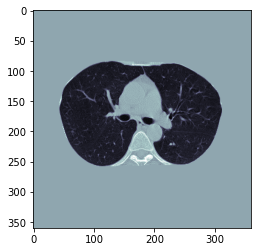

In [126]:
plt.imshow(img4[201,:,:], cmap=plt.cm.bone)
plt.show()

In [127]:
def zero_center(image):
    PIXEL_MEAN = 0.25 * 256
    image2 = image - PIXEL_MEAN
    return image2

In [128]:
img5 = zero_center(img4)

In [18]:
plt.figure(figsize = (10,10))
plt.imshow(img4[200,:,:], cmap=plt.cm.bone)
plt.show()

In [130]:
import numpy as np

#img_array = np.load('/DATA/jakaria_data/dataset/volumes_modified/s_0001_0363.npy')

In [ ]:
img_array.shape

In [ ]:
plt.imshow(img_array[0], cmap='gray')
plt.show()

In [ ]:
/DATA/jakaria_data/dataset/prepared_data/train/images

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/DATA/jakaria_data/dataset/prepared_data/train/images/10.png')
plt.figure(figsize = (10,10))
plt.imshow(img,cmap = 'gray')

#plt.show()

img = mpimg.imread('/DATA/jakaria_data/dataset/prepared_data/train/masks/10.png')
plt.imshow(img,cmap='Greens',alpha=0.3)


In [ ]:
img = mpimg.imread('/DATA/jakaria_data/logs/segmentation/predict_100000_epoch.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
import skimage.io as io
img = io.imread('/DATA/jakaria_data/resources/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd', plugin='simpleitk')

In [ ]:
img.shape

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(img[56],cmap='gray')

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(img[56])

In [ ]:
for i in range(img.shape[0]):
    unique, counts = np.unique(img[i], return_counts=True)
    if len(counts)>1:
        if counts[1]>10:
            print(i)
#print(unique)
#print(counts)

/DATA/jakaria_data/anaconda3/envs/jakaria_tensorflow_1/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
/DATA/jakaria_data/anaconda3/envs/jakaria_tensorflow_1/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
/DATA/jakaria_data/anaconda3/envs/jakaria_tensorflow_1/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


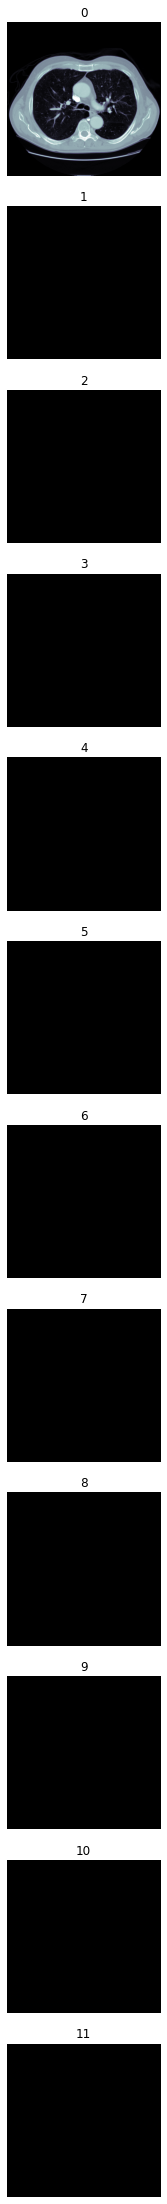

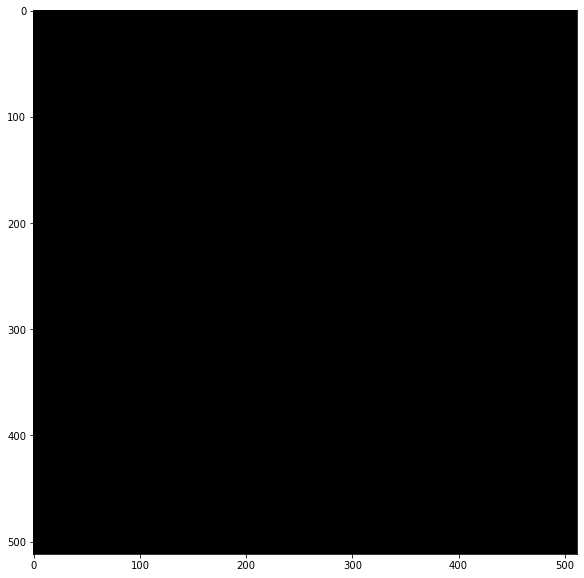

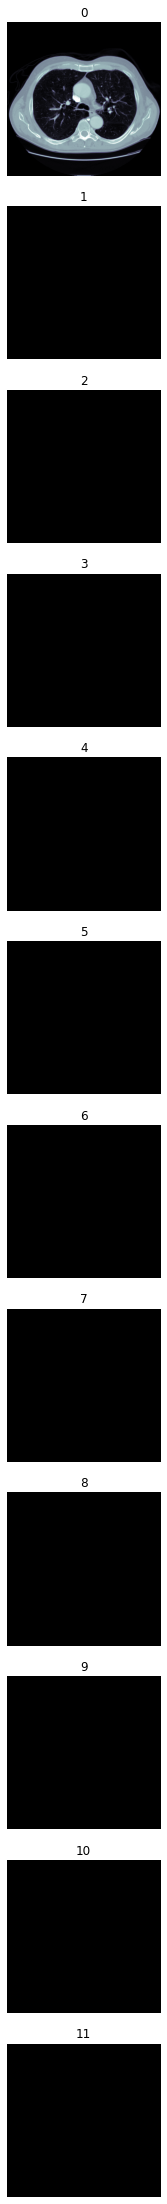

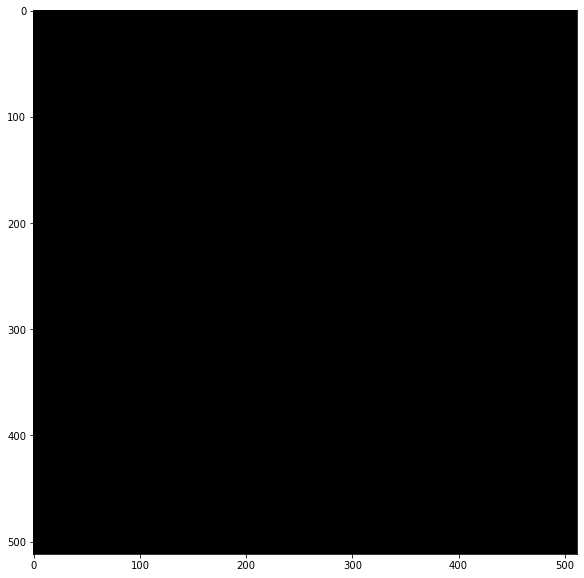

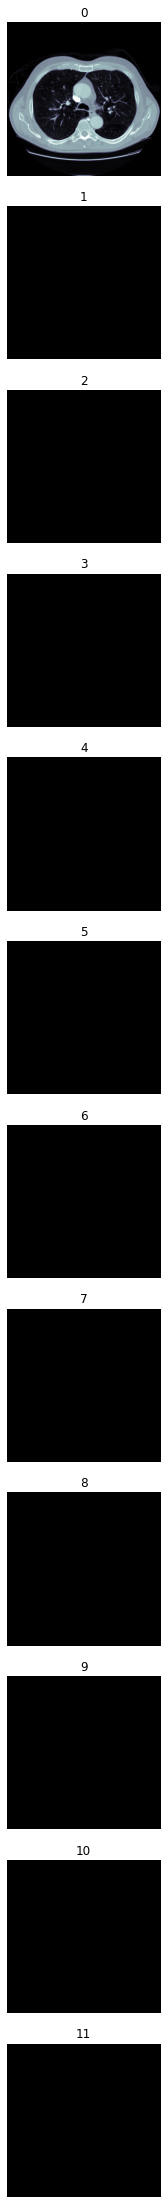

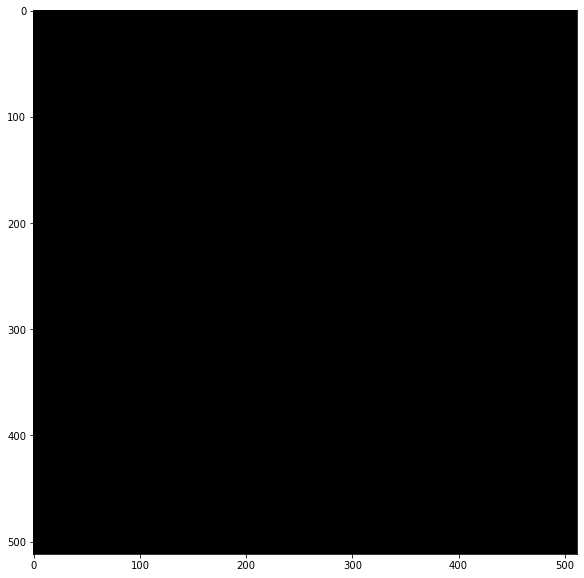

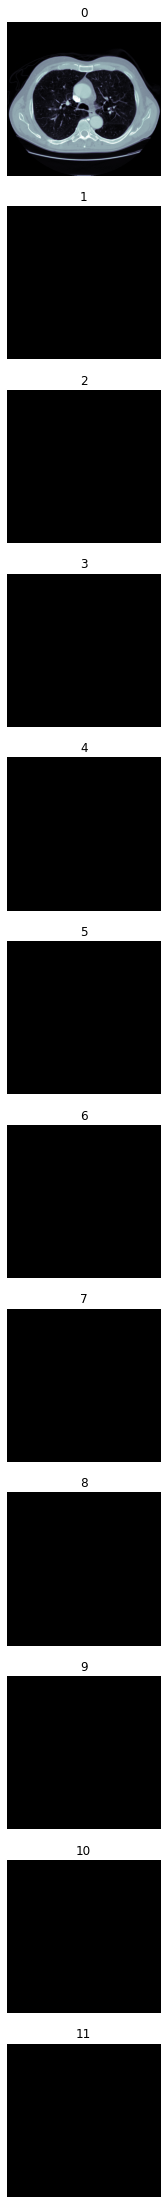

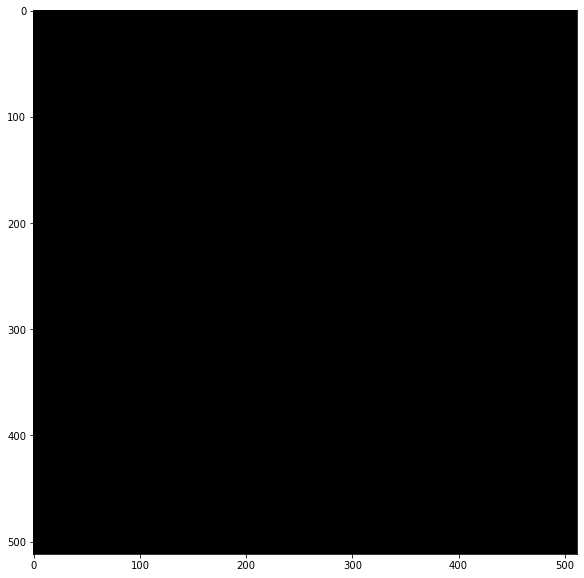

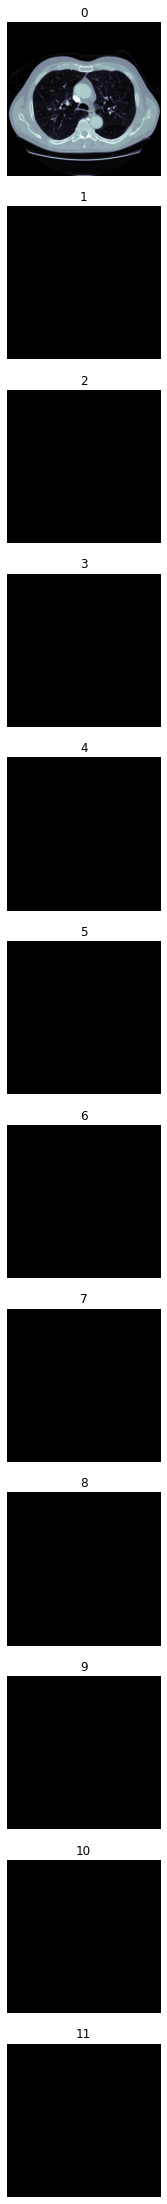

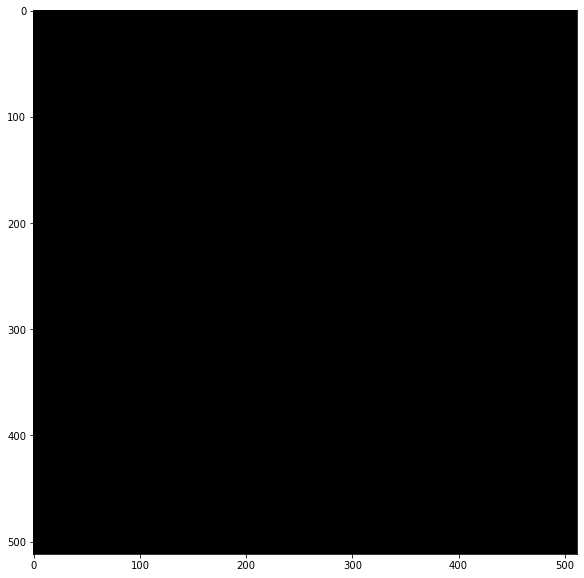

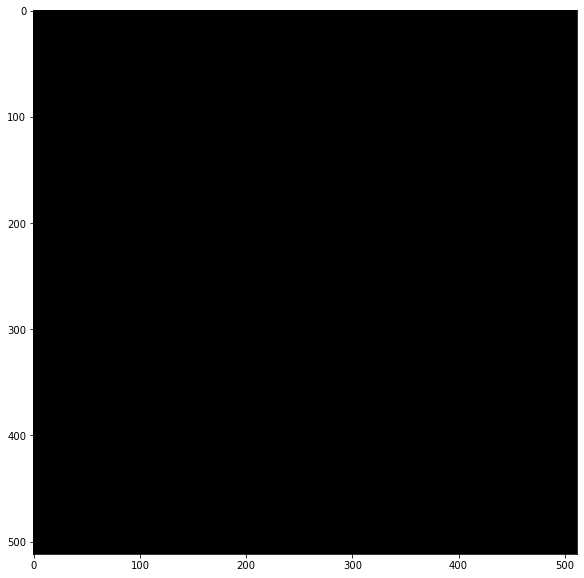

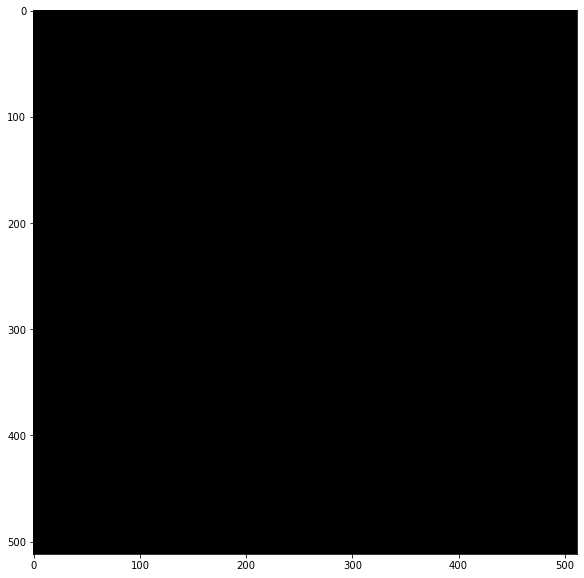

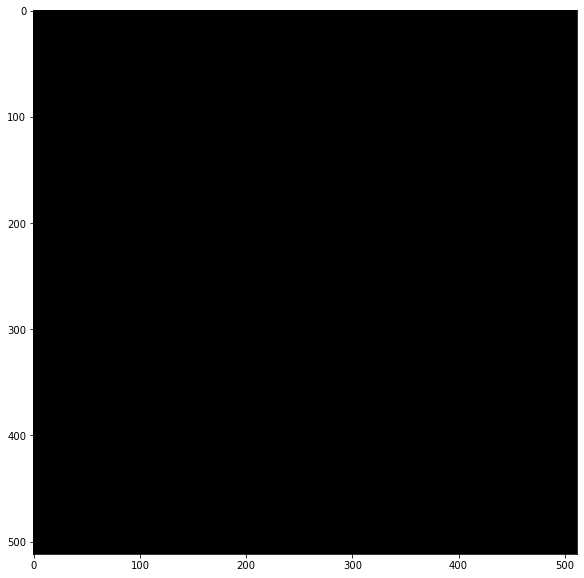

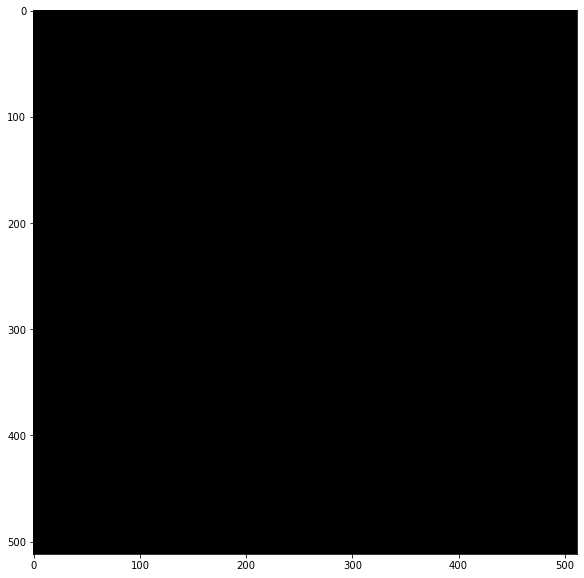

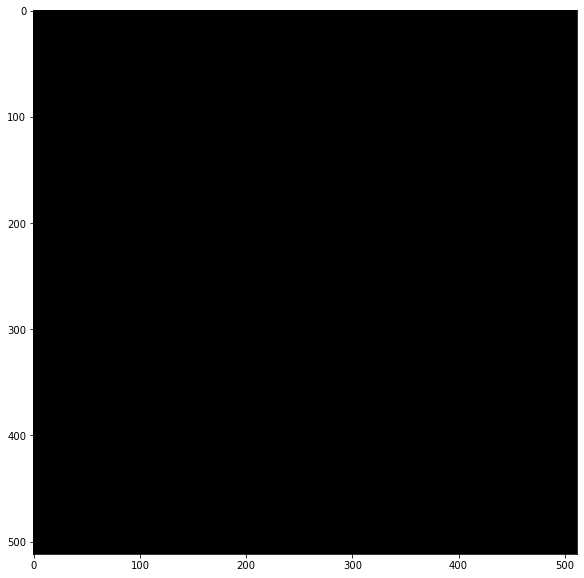

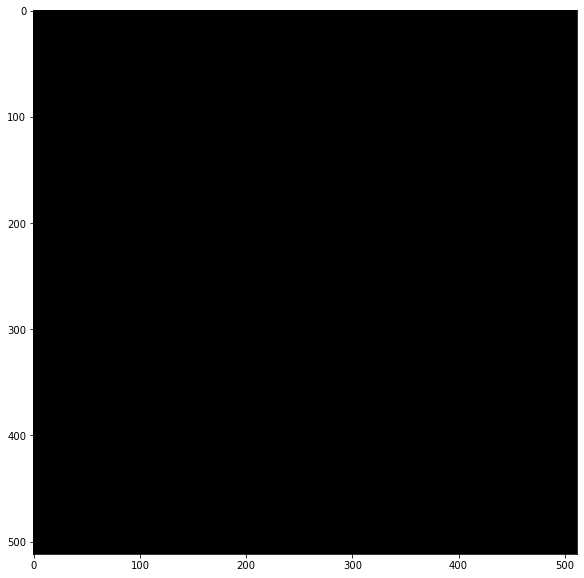

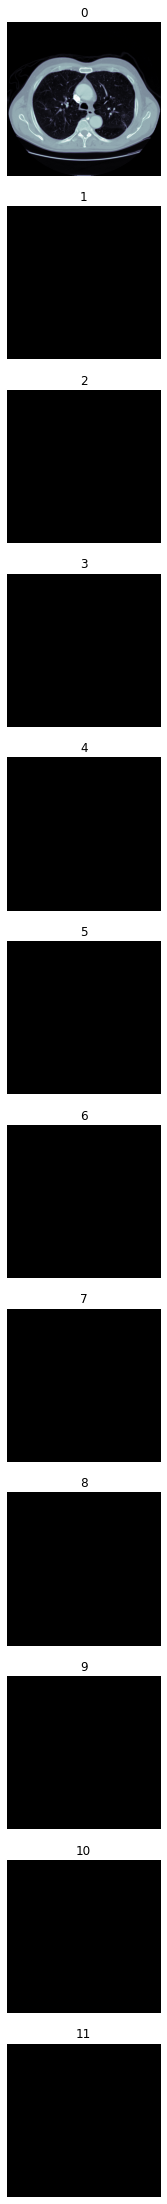

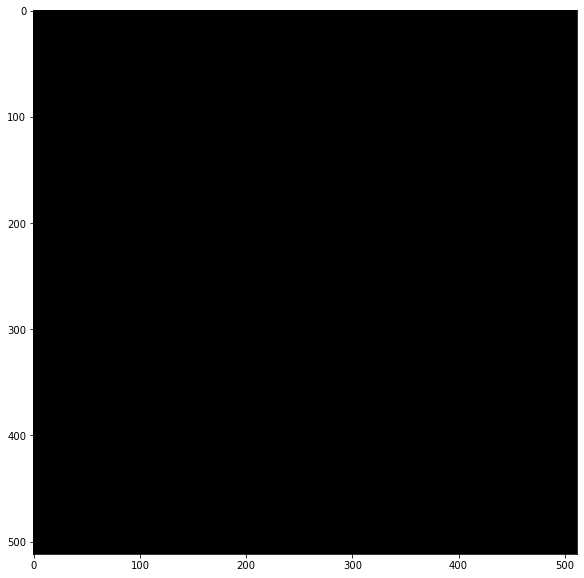

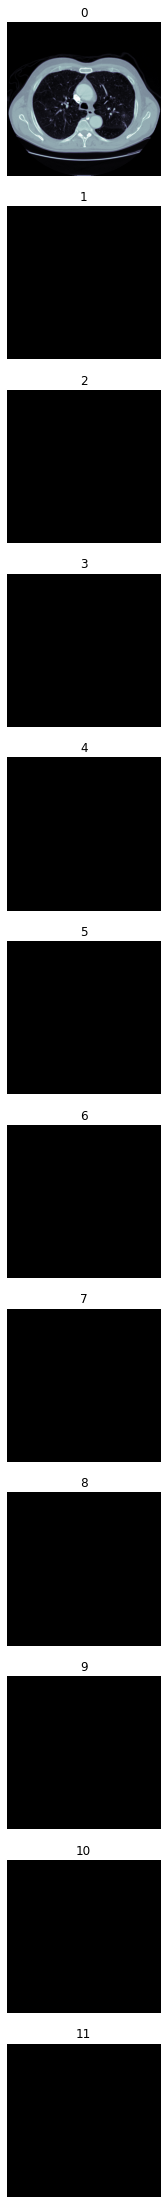

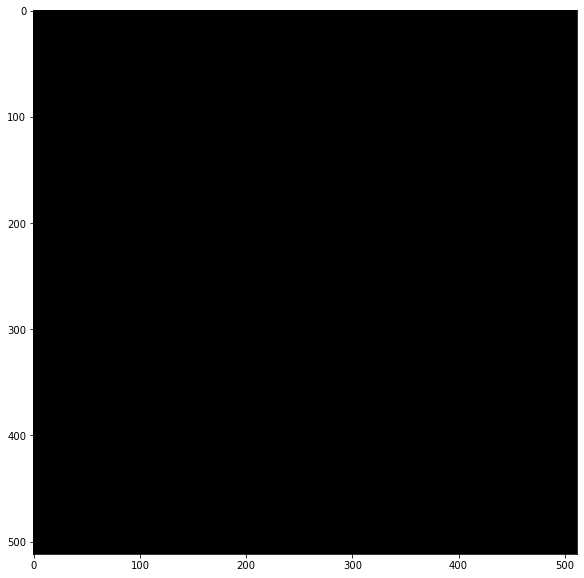

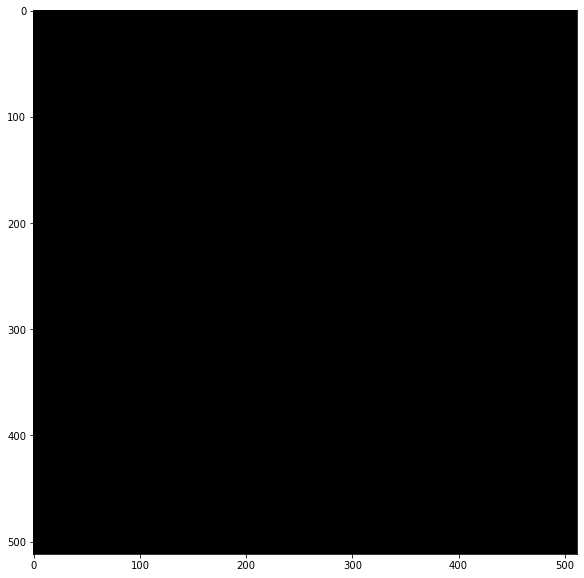

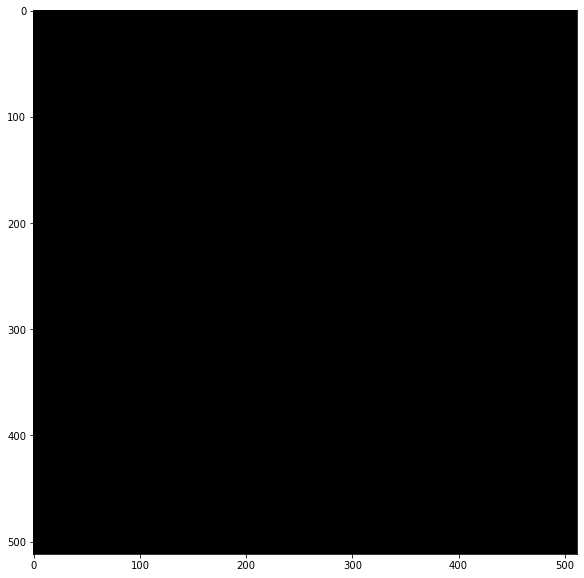

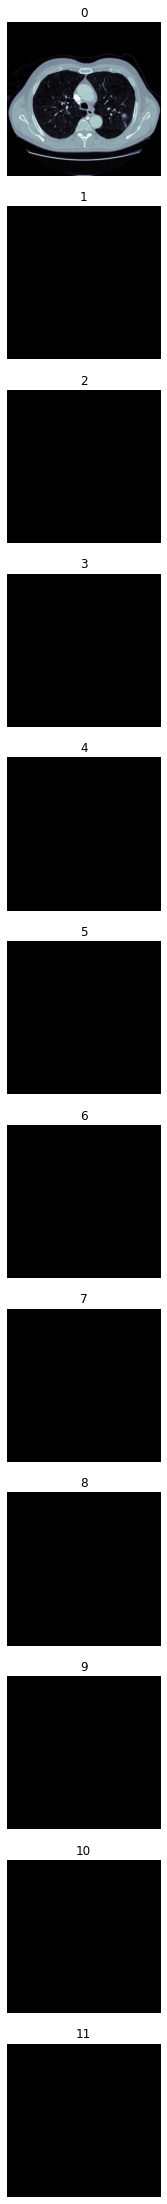

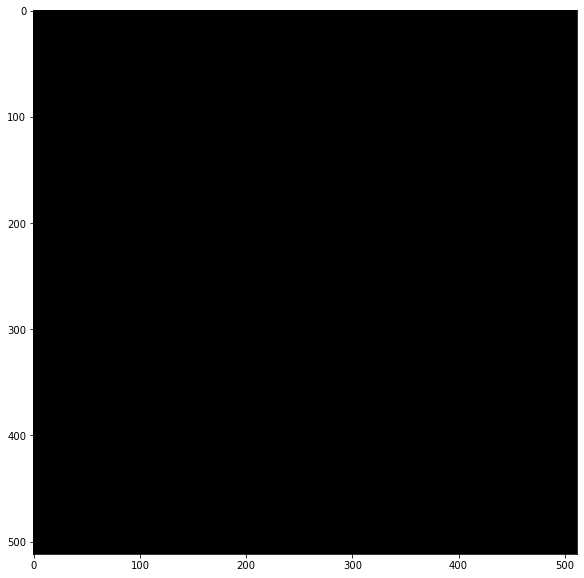

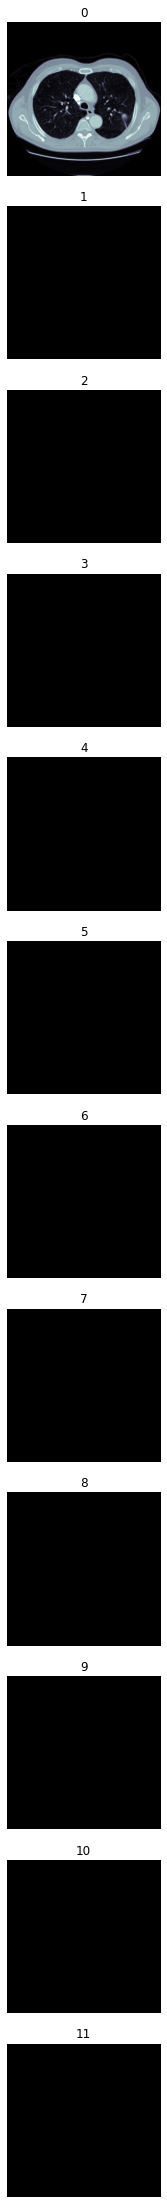

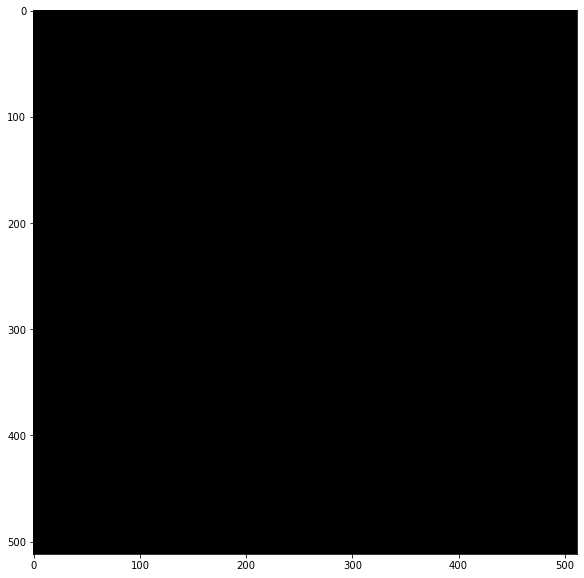

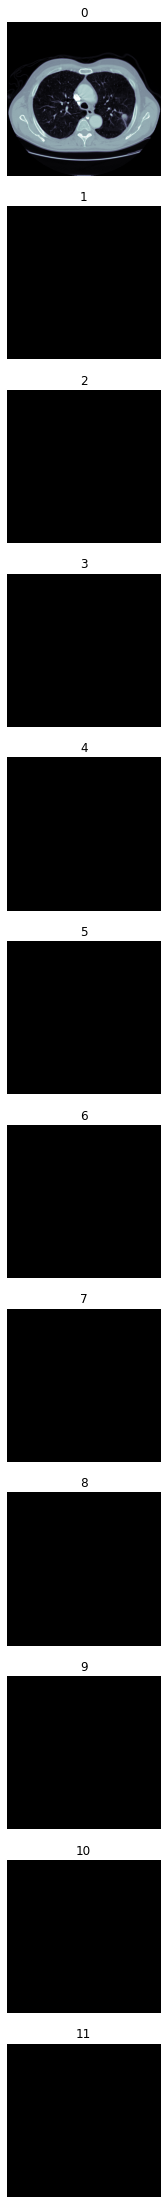

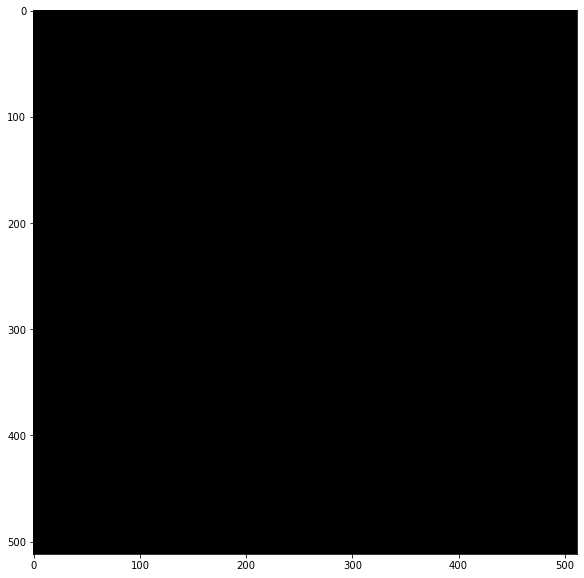

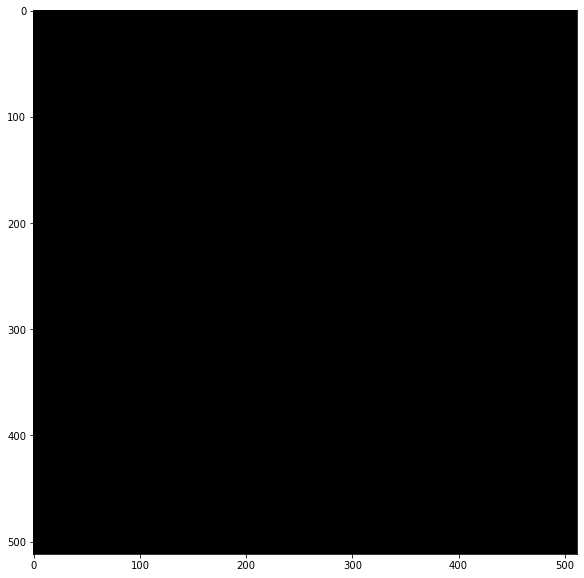

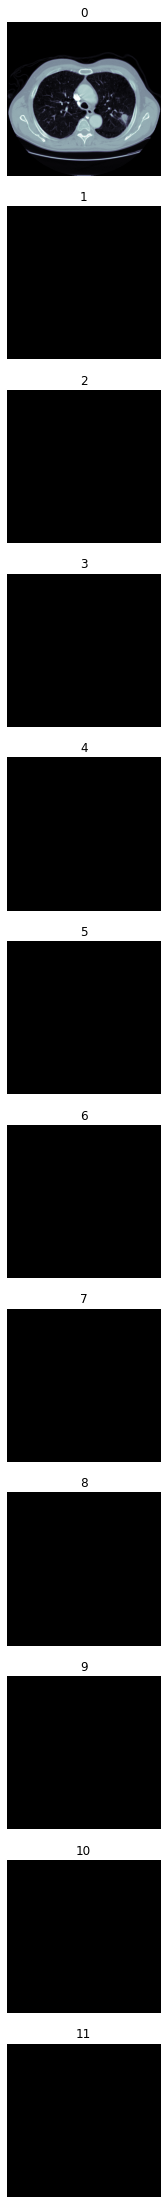

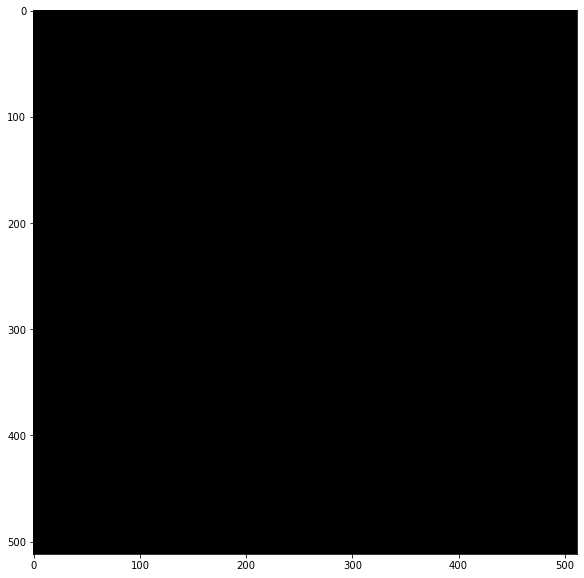

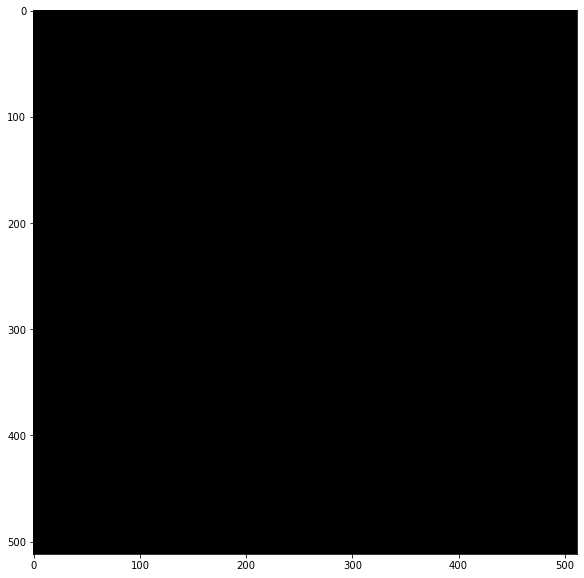

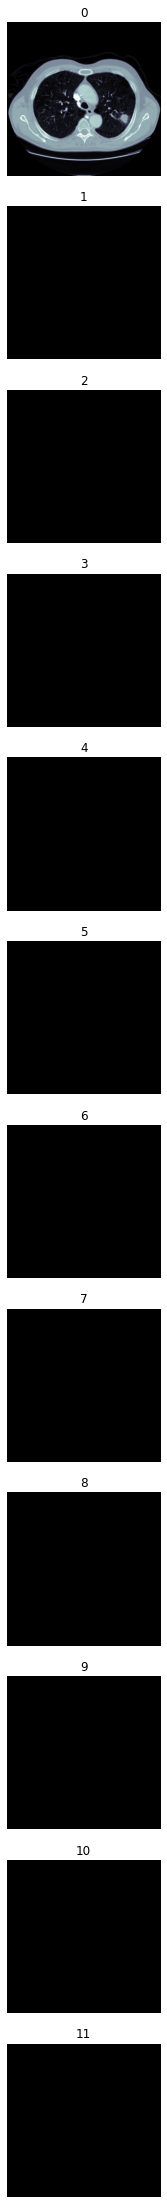

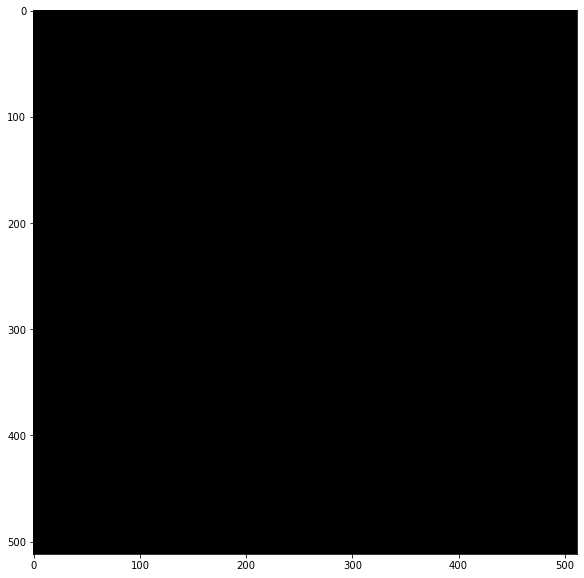

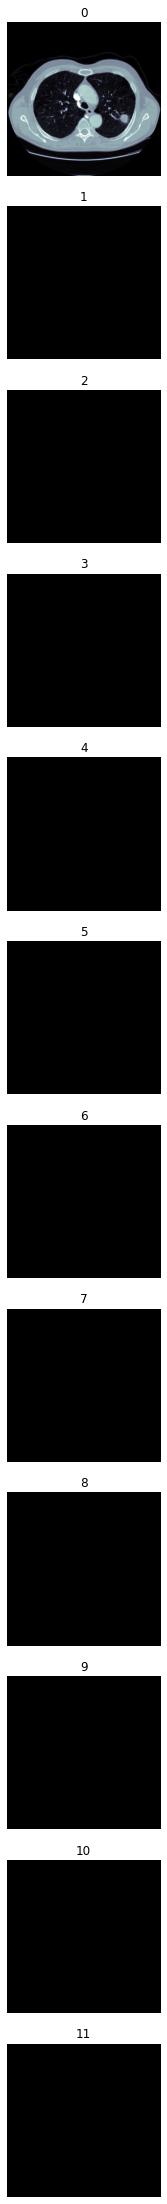

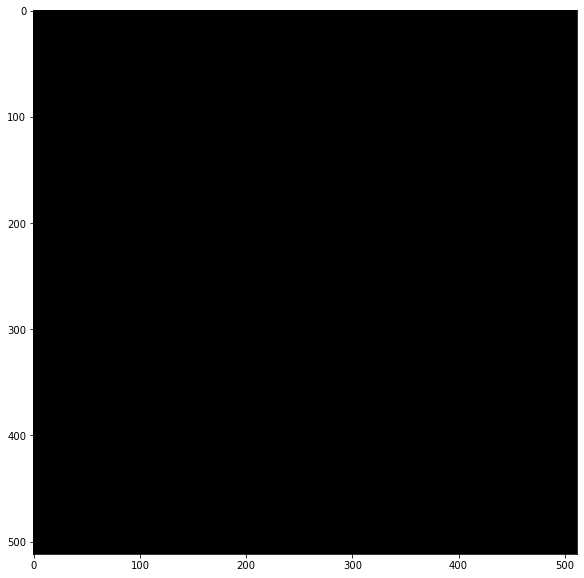

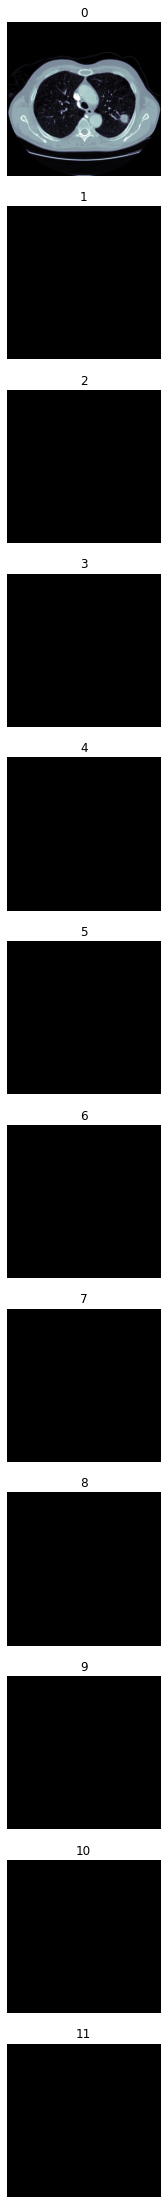

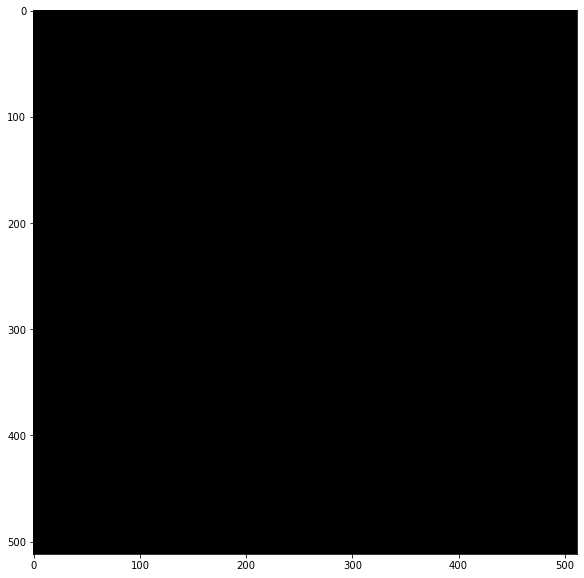

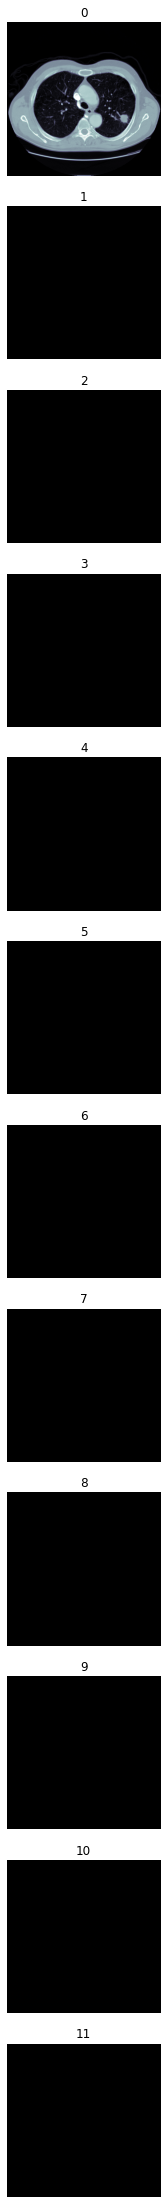

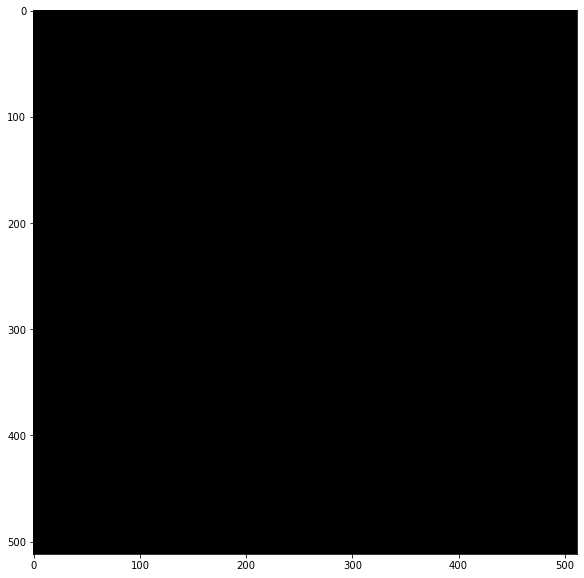

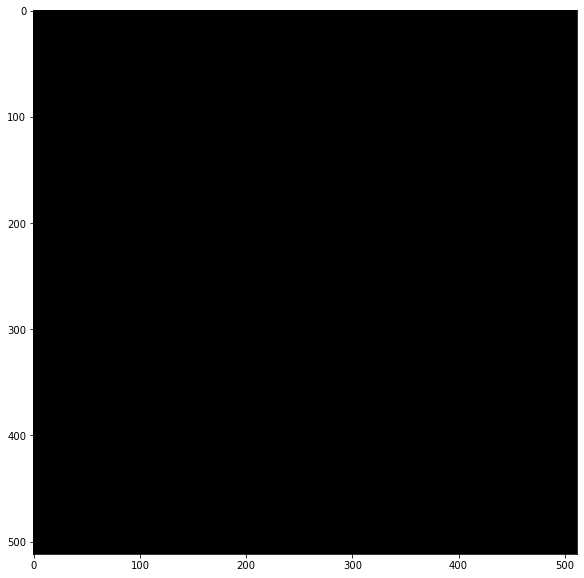

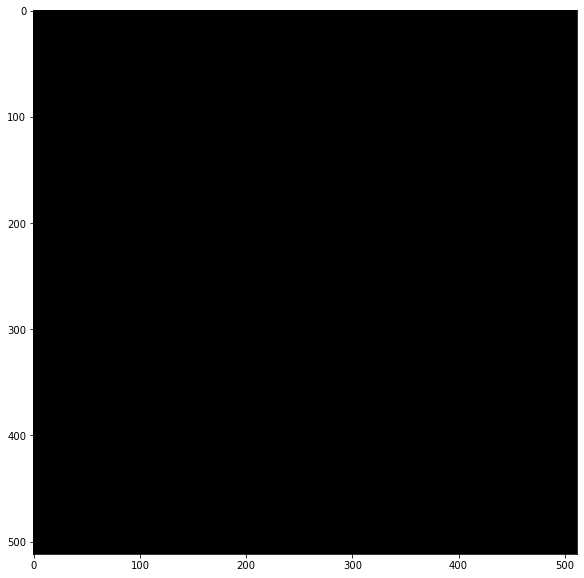

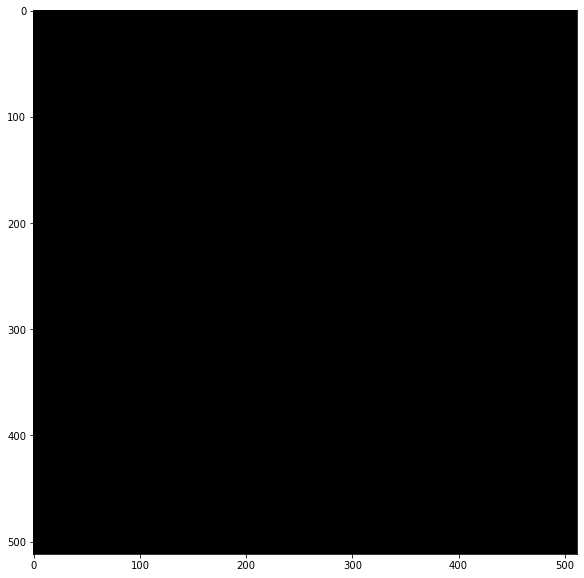

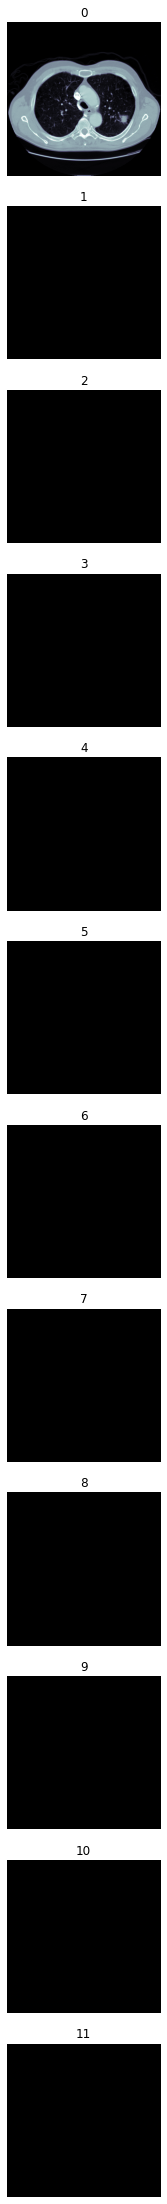

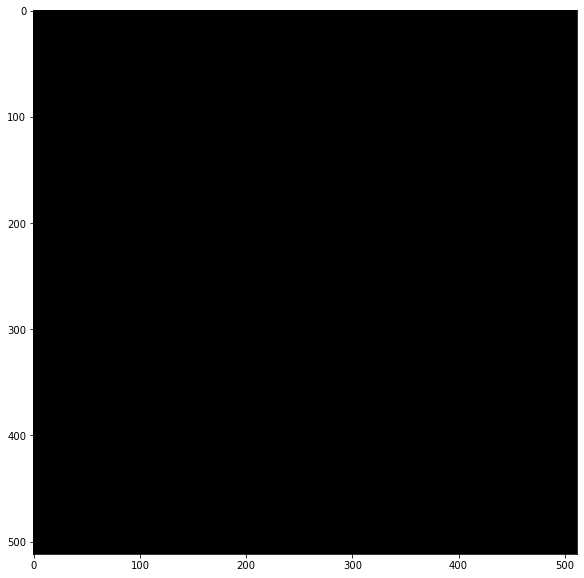

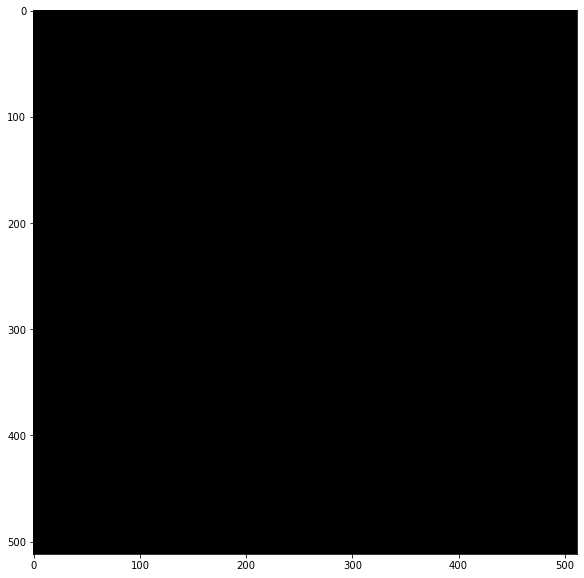

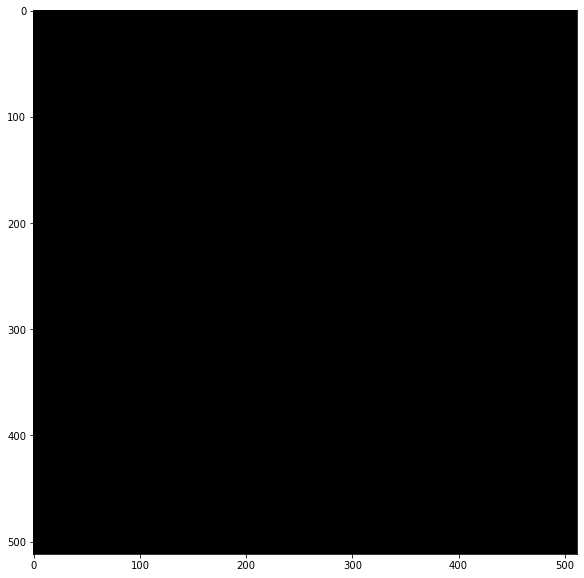

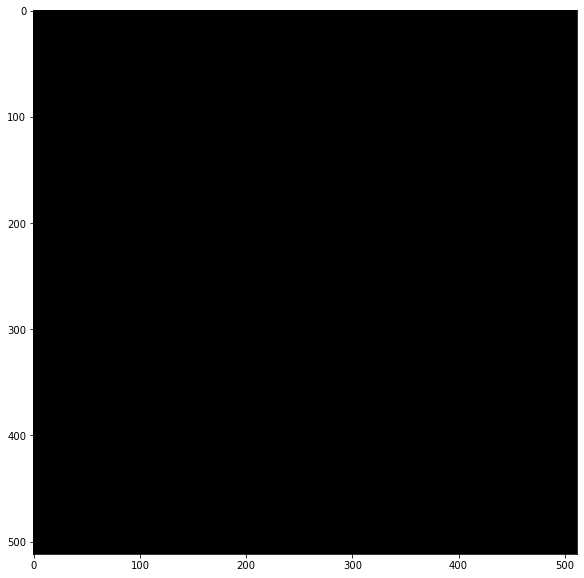

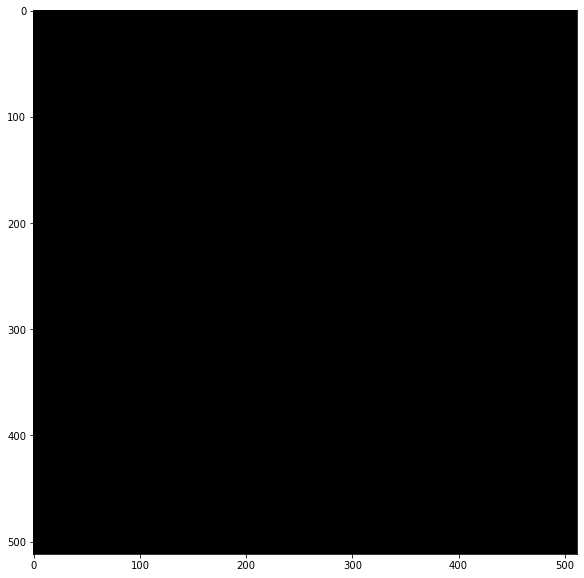

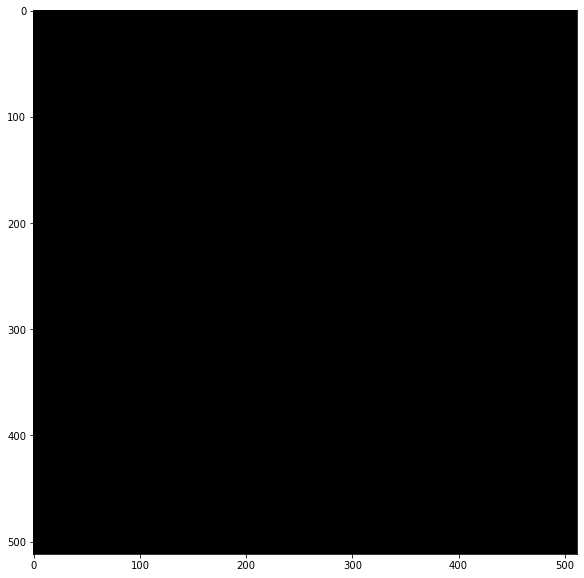

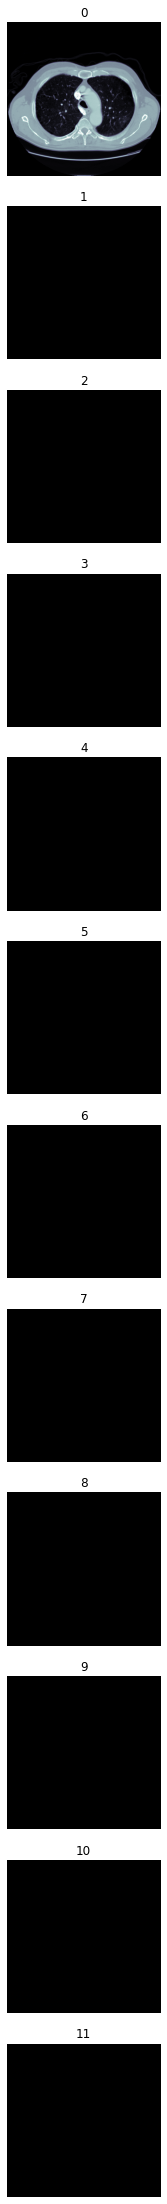

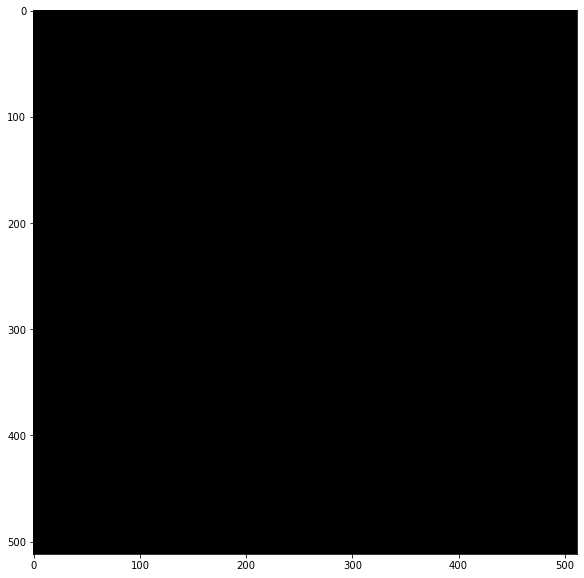

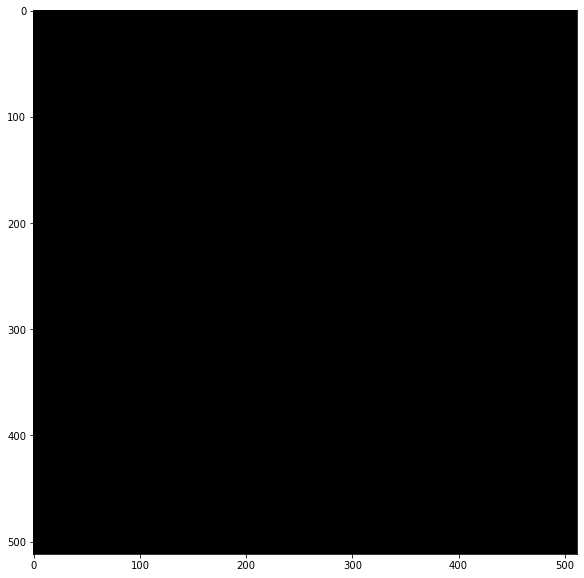

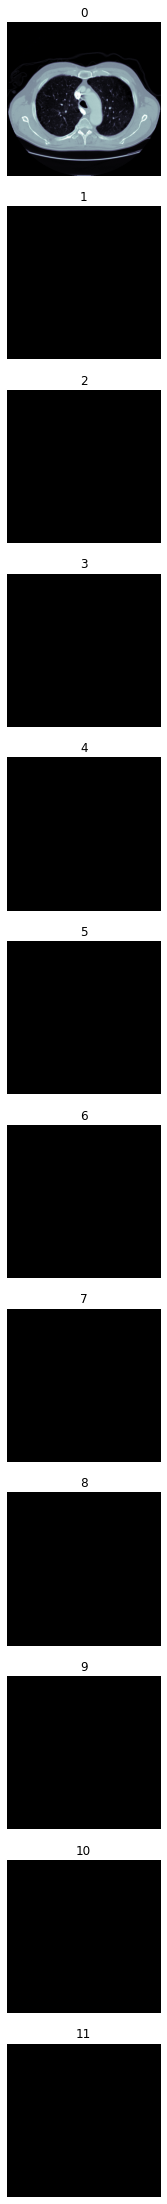

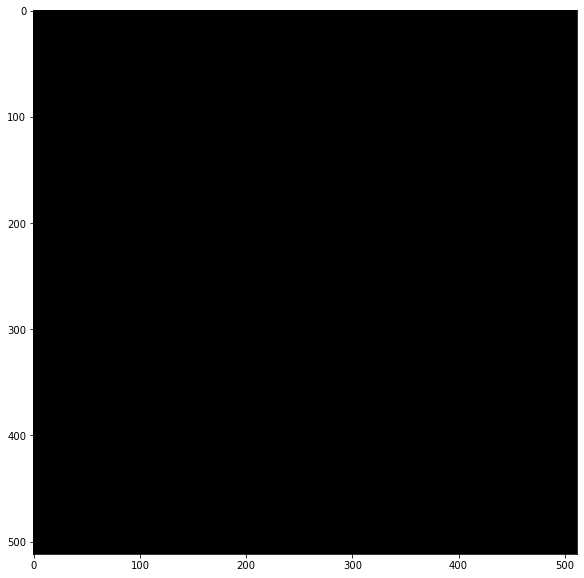

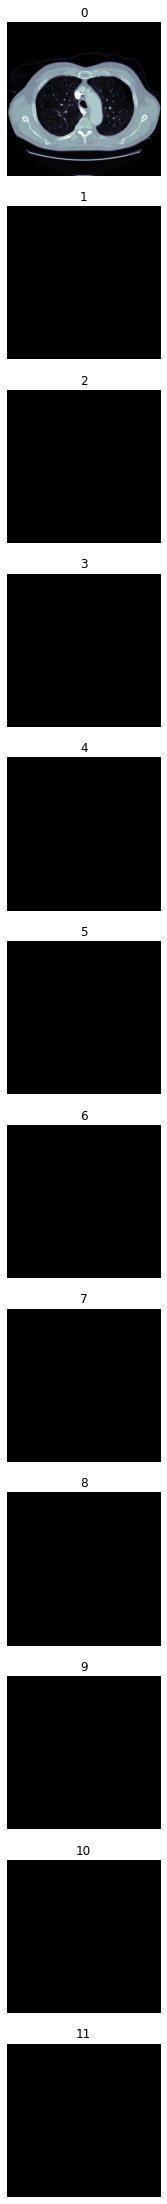

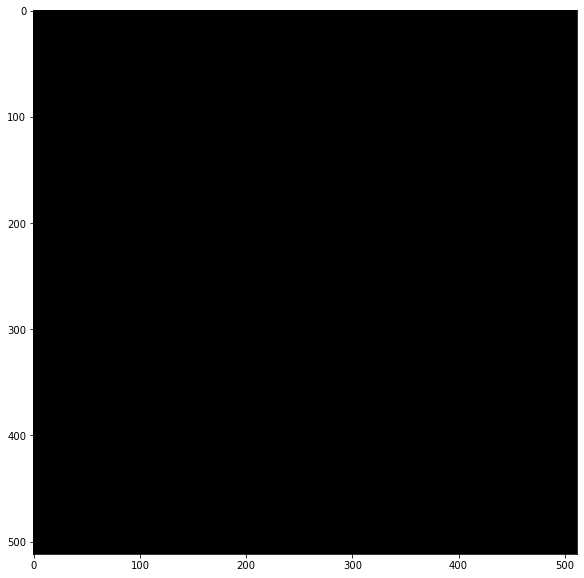

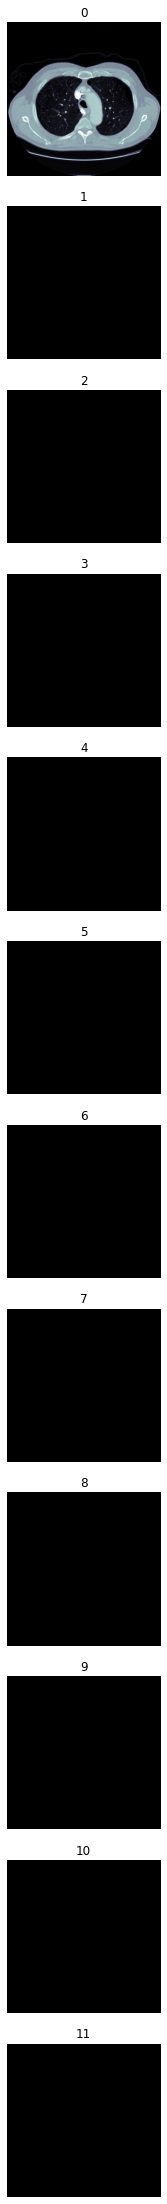

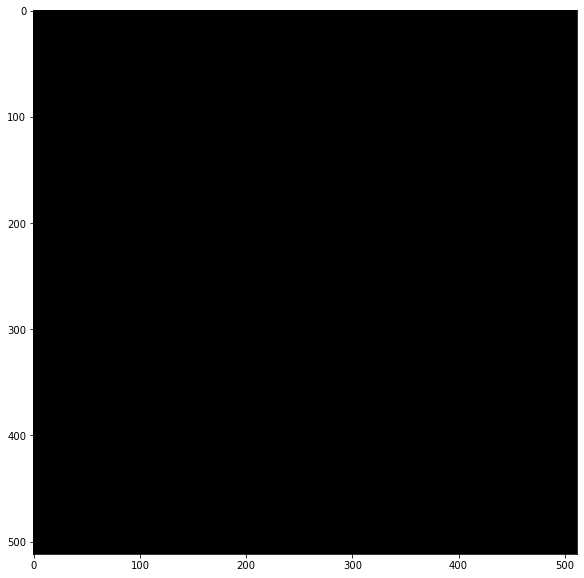

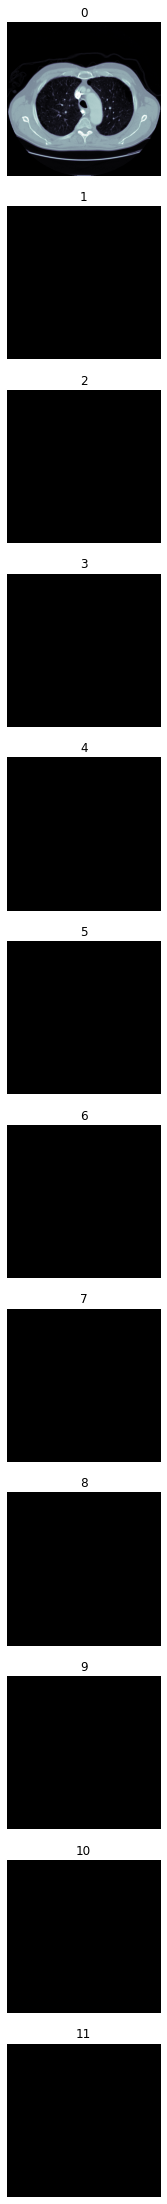

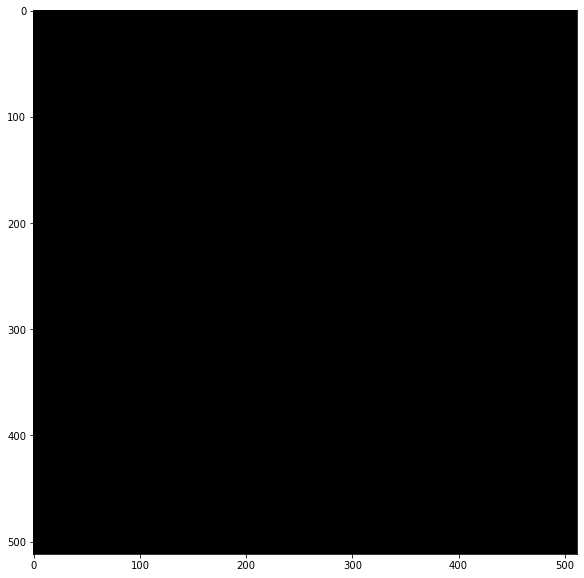

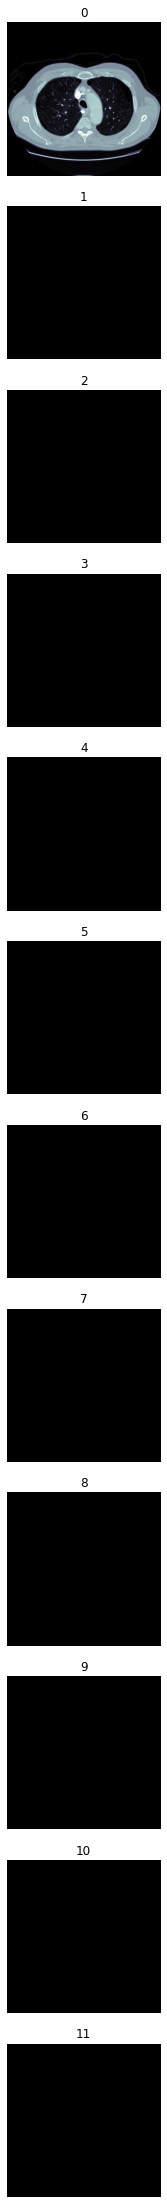

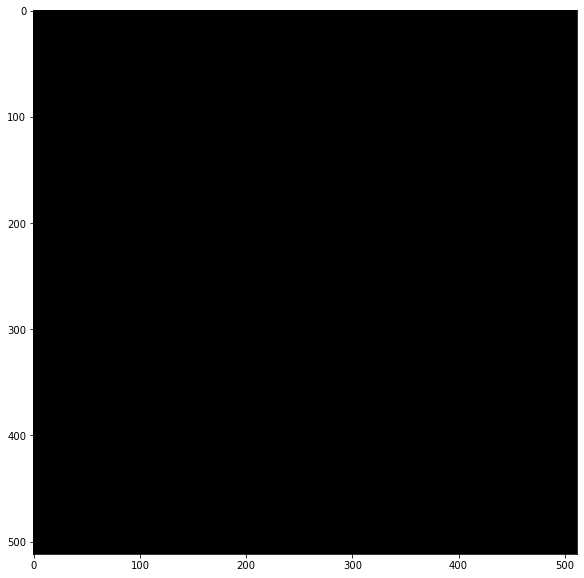

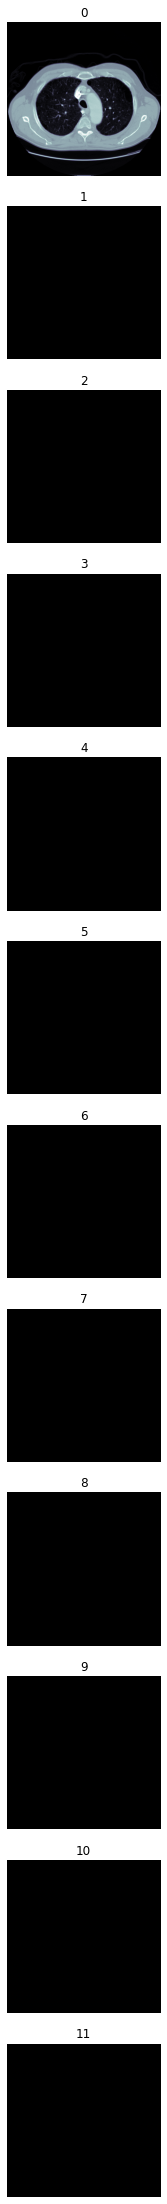

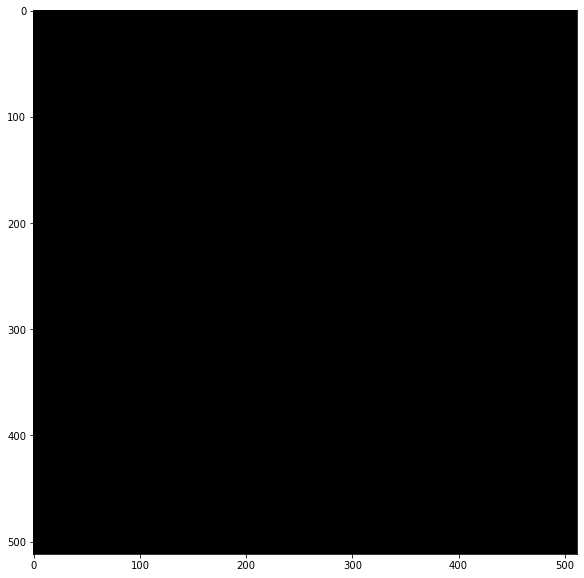

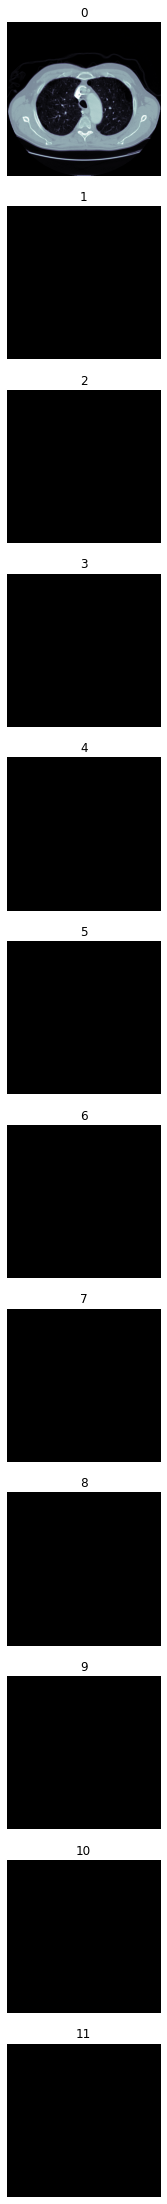

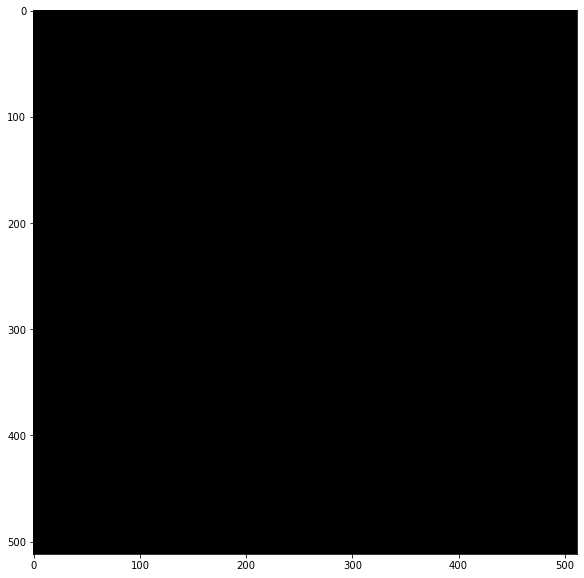

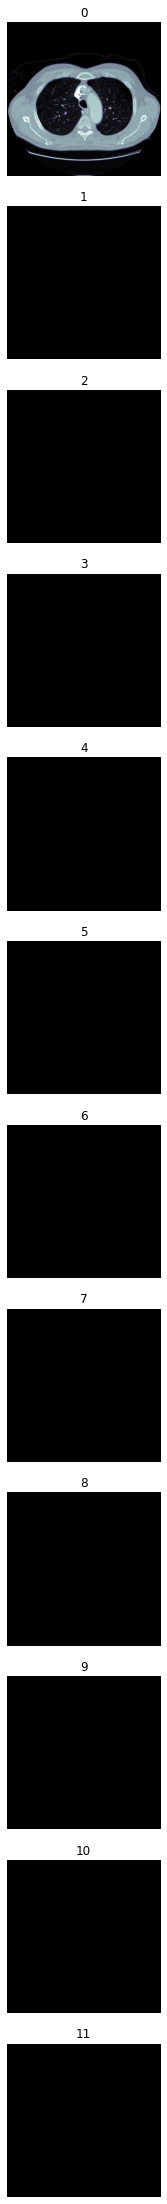

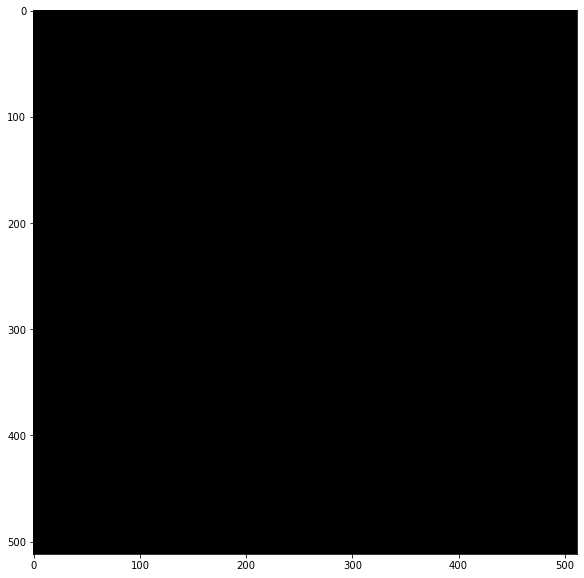

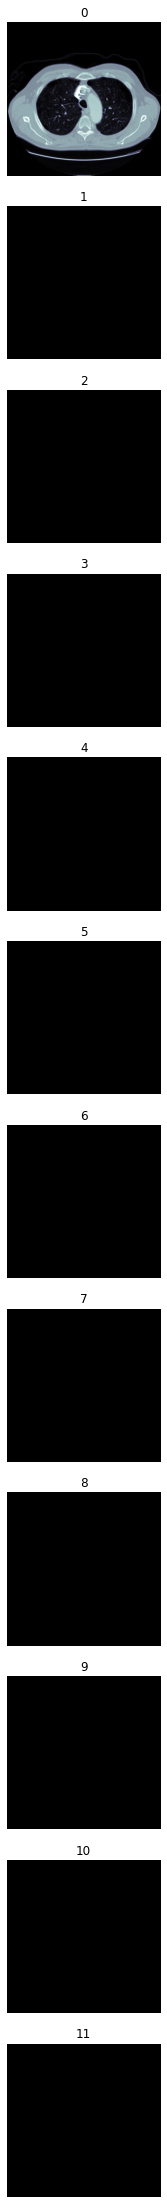

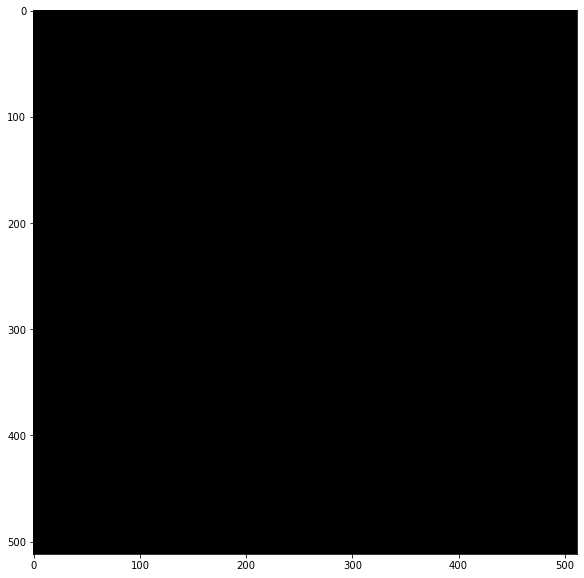

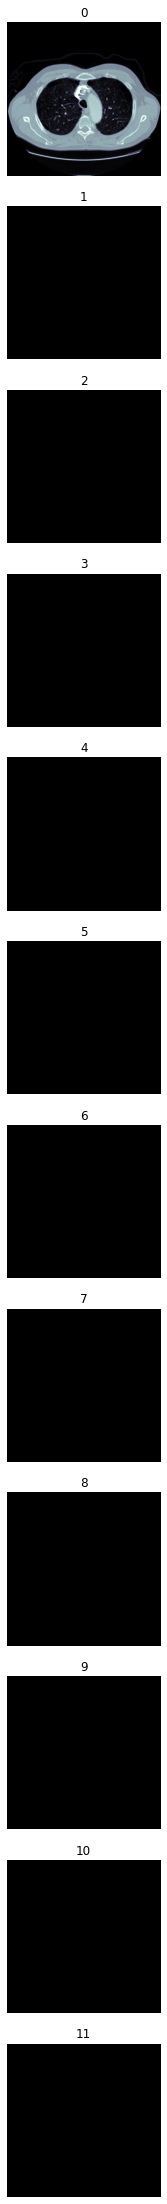

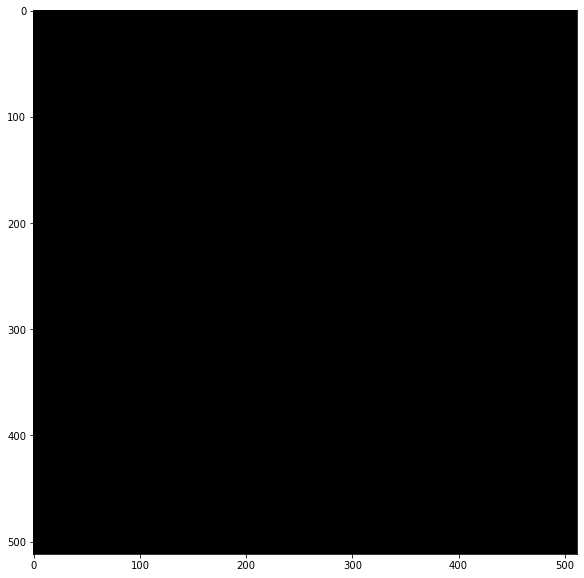

In [50]:
srcpath = "/DATA/jakaria_data/resources/processed/images/"
maskpath = "/DATA/jakaria_data/resources/processed/masks/"
j=1
for i in range(1):
        index = 0
        listsrc = []
        listmask = []
        for _ in os.listdir(srcpath + str(i)):
            image = cv2.imread(srcpath + str(i) + "/" + str(index) + ".bmp", cv2.IMREAD_GRAYSCALE)
            #label = cv2.imread(maskpath + str(i) + "/" + str(index) + ".bmp", cv2.IMREAD_GRAYSCALE)
            #unique, counts = np.unique(label, return_counts=True)     
            test_img = get_segmented_lungs(image, True)
            plt.figure(figsize = (10,10))
            plt.imshow(test_img, cmap='gray')

            index += 1

In [18]:
j=0
for i in range(100):
        index = 0
        listsrc = []
        listmask = []
        for _ in os.listdir(srcpath + str(i)):
            image = cv2.imread(srcpath + str(i) + "/" + str(index) + ".bmp", cv2.IMREAD_GRAYSCALE)
            label = cv2.imread(maskpath + str(i) + "/" + str(index) + ".bmp", cv2.IMREAD_GRAYSCALE)
            unique, counts = np.unique(label, return_counts=True)
            if len(counts)>1:
                if counts[1]>500:
                    #print(unique)
                    #print(counts)
                    #cv2.imwrite(filepath + str(z) + ".png", image)
                    #cv2.imwrite(filepath + str(z) + ".png", label)
                    print(j)
                    j=j+1
            index += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
from __future__ import print_function, division
import os
import SimpleITK as sitk
import cv2
import numpy as np
import pandas as pd
from glob import glob


def make_circle_mask(img):
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    # get the single external contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    if (np.sum(contours)<=0):
        mask = np.zeros(img.shape, dtype="uint8")
        return mask
    big_contour = max(contours, key=cv2.contourArea)
    
    rotrect = cv2.minAreaRect(big_contour)
    (center), (width,height), angle = rotrect
    
    mask = np.zeros(img.shape, dtype="uint8")
    mask = cv2.circle(mask, (int(center[0]), int(center[1])), int((width+height)/4), 255, -1)
    
    return mask

def getRangImageDepth(image):
    """
    :param image:
    :return:range of image depth
    """
    # start, end = np.where(image)[0][[0, -1]]
    fistflag = True
    startposition = 0
    endposition = 0
    for z in range(image.shape[0]):
        notzeroflag = np.max(image[z])
        if notzeroflag and fistflag:
            startposition = z
            fistflag = False
        if notzeroflag:
            endposition = z
    return startposition, endposition


def resize_image_itk(itkimage, newSpacing, resamplemethod=sitk.sitkNearestNeighbor):
    """
    image resize withe sitk resampleImageFilter
    :param itkimage:
    :param newSpacing:such as [1,1,1]
    :param resamplemethod:
    :return:
    """
    newSpacing = np.array(newSpacing, float)
    originSpcaing = itkimage.GetSpacing()
    resampler = sitk.ResampleImageFilter()
    originSize = itkimage.GetSize()
    factor = newSpacing / originSpcaing
    newSize = originSize / factor
    newSize = newSize.astype(np.int)
    resampler.SetReferenceImage(itkimage)
    resampler.SetOutputSpacing(newSpacing.tolist())
    resampler.SetSize(newSize.tolist())
    resampler.SetTransform(sitk.Transform(3, sitk.sitkIdentity))
    resampler.SetInterpolator(resamplemethod)
    itkimgResampled = resampler.Execute(itkimage)
    #if resamplemethod == sitk.sitkNearestNeighbor:
        #itkimgResampled = sitk.Threshold(itkimgResampled, 0, 1.0, 255)
    imgResampled = sitk.GetArrayFromImage(itkimgResampled)
    return imgResampled, itkimgResampled


def load_itk(filename):
    """
    load mhd files and normalization 0-255
    :param filename:
    :return:
    """
    rescalFilt = sitk.RescaleIntensityImageFilter()
    rescalFilt.SetOutputMaximum(255)
    rescalFilt.SetOutputMinimum(0)
    # Reads the image using SimpleITK
    itkimage = rescalFilt.Execute(sitk.Cast(sitk.ReadImage(filename), sitk.sitkFloat32))
    return itkimage


def load_itkfilewithtrucation(filename, upper=200, lower=-200):
    """
    load mhd files,set truncted value range and normalization 0-255
    :param filename:
    :param upper:
    :param lower:
    :return:
    """
    # 1,tructed outside of lungs value
    srcitkimage = sitk.Cast(sitk.ReadImage(filename), sitk.sitkFloat32)
    srcitkimagearray = sitk.GetArrayFromImage(srcitkimage)
    srcitkimagearray[srcitkimagearray > upper] = upper
    srcitkimagearray[srcitkimagearray < lower] = lower
    # 2,get tructed outside of lungs value image
    sitktructedimage = sitk.GetImageFromArray(srcitkimagearray)
    origin = np.array(srcitkimage.GetOrigin())
    spacing = np.array(srcitkimage.GetSpacing())
    sitktructedimage.SetSpacing(spacing)
    sitktructedimage.SetOrigin(origin)
    # 3 normalization value to 0-255
    rescalFilt = sitk.RescaleIntensityImageFilter()
    rescalFilt.SetOutputMaximum(255)
    rescalFilt.SetOutputMinimum(0)
    itkimage = rescalFilt.Execute(sitk.Cast(sitktructedimage, sitk.sitkFloat32))
    return itkimage

# Helper function to get rows in data frame associated with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return (f)

def processOriginaltraindata():
    expandslice = 13
    trainImage = "/DATA/jakaria_data/resources/2d_data/images/"
    trainMask = "/DATA/jakaria_data/resources/2d_data/masks/"
    trainMask_c = "/DATA/jakaria_data/resources/2d_data/masks_c/"
    """
    load itk image,change z Spacing value to 1,and save image ,liver mask ,tumor mask
    :return:None
    """
    seriesindex = 272
    for subsetindex in range(5,10): #range(10)
        luna_path = "/DATA/jakaria_data/resources/"
        luna_subset_path = luna_path + "subset" + str(subsetindex) + "/"
        output_path = "/DATA/jakaria_data/resources/masks/"
        luna_subset_mask_path = output_path + "subset" + str(subsetindex) + "/"
        file_list = glob(luna_subset_path + "*.mhd")
        
        file_list_path=[]
        for i in range(len(file_list)):
            file_list_path.append(file_list[i][0:-4])
        
        luna_csv_path = "/DATA/jakaria_data/resources/"
        df_node = pd.read_csv(luna_csv_path + "annotations.csv")
        df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list_path, file_name))
        df_node = df_node.dropna()
        
        for fcount in range(len(file_list)): #len(file_list)
            
            mini_df = df_node[df_node["file"] == file_list[fcount][0:-4]]
            print(mini_df.shape[0])
            print("debug: "+str(subsetindex)+" "+str(fcount))
            if mini_df.shape[0] == 0:
                              continue
            # 1 load itk image and truncate value with upper and lower
            #src = load_itkfilewithtrucation(file_list[fcount], 600, -1000)
            src = sitk.ReadImage(file_list[fcount])
            sub_img_file = file_list[fcount][len(luna_subset_path):-4]
            seg = sitk.ReadImage(luna_subset_mask_path + sub_img_file + "_segmentation.mhd", sitk.sitkUInt8)
            segzspace = seg.GetSpacing()[-1]
            # 2 change z spacing >1.0 to 1.0
            if segzspace > 1.0:
                _, seg = resize_image_itk(seg, (seg.GetSpacing()[0], seg.GetSpacing()[1], 1.0),
                                          resamplemethod=sitk.sitkNearestNeighbor)
                _, src = resize_image_itk(src, (src.GetSpacing()[0], src.GetSpacing()[1], 1.0),
                                          resamplemethod=sitk.sitkLinear)
            # 3 get resample array(image and segmask)
            segimg = sitk.GetArrayFromImage(seg)
            srcimg = sitk.GetArrayFromImage(src)

            trainimagefile = trainImage + str(seriesindex)
            trainMaskfile = trainMask + str(seriesindex)
            trainMaskfile_c = trainMask_c + str(seriesindex)
            if not os.path.exists(trainimagefile):
                os.makedirs(trainimagefile)
            if not os.path.exists(trainMaskfile):
                os.makedirs(trainMaskfile)
            if not os.path.exists(trainMaskfile_c):
                os.makedirs(trainMaskfile_c)    
            # 4 get mask
            seg_liverimage = segimg.copy()
            seg_liverimage[segimg > 0] = 255
            # 5 get the roi range of mask,and expand number slices before and after,and get expand range roi image
            startpostion, endpostion = getRangImageDepth(seg_liverimage)
            if startpostion == endpostion:
                continue
            imagez = np.shape(seg_liverimage)[0]
            startpostion = startpostion - expandslice
            endpostion = endpostion + expandslice
            if startpostion < 0:
                startpostion = 0
            if endpostion > imagez:
                endpostion = imagez
            srcimg = srcimg[startpostion:endpostion, :, :]
            seg_liverimage = seg_liverimage[startpostion:endpostion, :, :]
            # 6 write src, liver mask and tumor mask image
            for z in range(seg_liverimage.shape[0]): # range(seg_liverimage.shape[0])
                srcimg[z] = get_segmented_lungs(srcimg[z])
                srcimg[z] = normalize(srcimg[z])
                srcimg[z] = zero_center(srcimg[z])
                srcimg[z] = np.clip(srcimg[z], 0, 255).astype('uint8')
                #seg_liverimage[z] = zero_center(seg_liverimage[z])
                seg_liverimage_c = make_circle_mask(seg_liverimage[z])
                cv2.imwrite(trainimagefile + "/" + str(z) + ".png", srcimg[z])
                cv2.imwrite(trainMaskfile + "/" + str(z) + ".png", seg_liverimage[z])
                seg_liverimage[z] = make_circle_mask(seg_liverimage[z])
                cv2.imwrite(trainMaskfile_c + "/" + str(z) + ".png", seg_liverimage[z])
            seriesindex += 1

In [19]:
processOriginaltraindata()

1
debug: 5 0
2
debug: 5 1
0
debug: 5 2
0
debug: 5 3
1
debug: 5 4
2
debug: 5 5
2
debug: 5 6
0
debug: 5 7
1
debug: 5 8
0
debug: 5 9
3
debug: 5 10
1
debug: 5 11
1
debug: 5 12
0
debug: 5 13
1
debug: 5 14
2
debug: 5 15
1
debug: 5 16
1
debug: 5 17
2
debug: 5 18
1
debug: 5 19
0
debug: 5 20
9
debug: 5 21
3
debug: 5 22
0
debug: 5 23
6
debug: 5 24
6
debug: 5 25
0
debug: 5 26
2
debug: 5 27
2
debug: 5 28
0
debug: 5 29
5
debug: 5 30
0
debug: 5 31
1
debug: 5 32
1
debug: 5 33
0
debug: 5 34
0
debug: 5 35
0
debug: 5 36
0
debug: 5 37
1
debug: 5 38
0
debug: 5 39
1
debug: 5 40
3
debug: 5 41
1
debug: 5 42
0
debug: 5 43
0
debug: 5 44
1
debug: 5 45
5
debug: 5 46
1
debug: 5 47
1
debug: 5 48
0
debug: 5 49
1
debug: 5 50
0
debug: 5 51
0
debug: 5 52
0
debug: 5 53
0
debug: 5 54
0
debug: 5 55
0
debug: 5 56
2
debug: 5 57
2
debug: 5 58
4
debug: 5 59
0
debug: 5 60
0
debug: 5 61
0
debug: 5 62
2
debug: 5 63
0
debug: 5 64
1
debug: 5 65
0
debug: 5 66
2
debug: 5 67
2
debug: 5 68
0
debug: 5 69
0
debug: 5 70
0
debug: 5 71
0


In [106]:
import skimage.io as io
img = io.imread('/DATA/jakaria_data/resources/2d_data/masks/0/31.png')
imgr = io.imread('/DATA/jakaria_data/resources/2d_data/images/0/31.png')
img1 = io.imread('/DATA/jakaria_data/dataset/prepared_data/train/masks/3.png')

In [107]:
img.shape

(512, 512)

In [108]:
unique, counts = np.unique(img, return_counts=True)
print(unique)
print(counts)

[  0 255]
[261303    841]


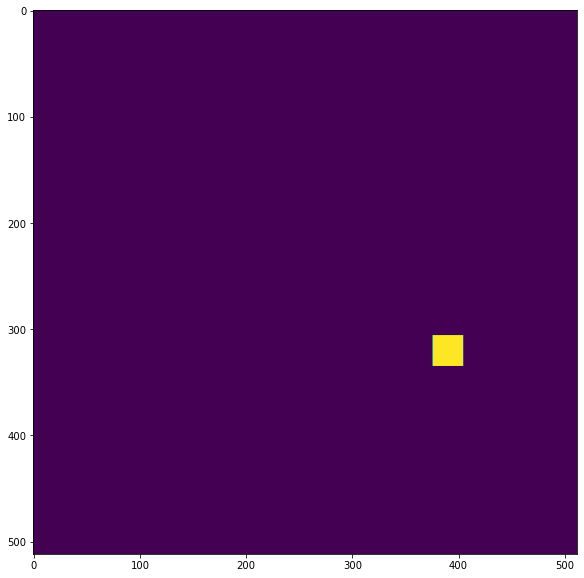

In [109]:
plt.figure(figsize=(10,10))
plt.imshow(img)

In [73]:
img.dtype

dtype('uint8')

In [124]:
thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# get the single external contours
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)
np.sum(contours)

2840

In [78]:
print(big_contour)

[[[376 306]]

 [[376 334]]

 [[404 334]]

 [[404 306]]]


In [79]:
rotrect = cv2.minAreaRect(big_contour)
(center), (width,height), angle = rotrect

In [97]:
print(center, width, height, angle)

(390.0, 320.0) 28.0 28.0 90.0


In [101]:
center[0]

390.0

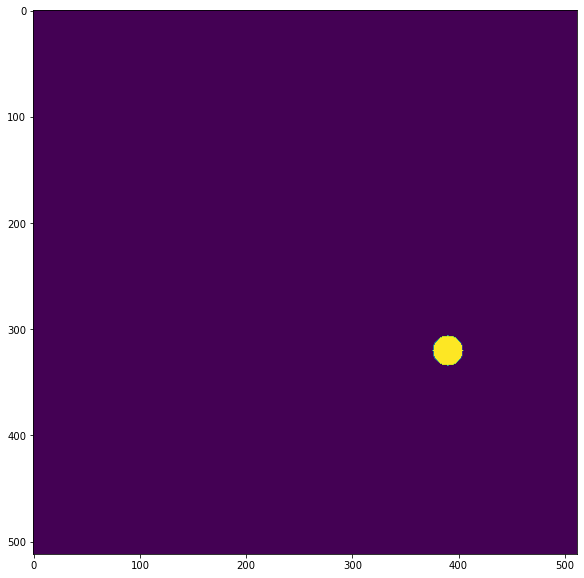

In [111]:
mask = np.zeros(img.shape, dtype="uint8")
mask = cv2.circle(mask, (int(center[0]), int(center[1])), int((width+height)/4), 255, -1)
# show the output mask
plt.figure(figsize=(10,10))
plt.imshow(mask)

In [112]:
unique, counts = np.unique(mask, return_counts=True)
print(unique)
print(counts)

[  0 255]
[261531    613]


In [13]:
seriesindex = 0
for subsetindex in range(5:10): #range(10)
    luna_path = "/DATA/jakaria_data/resources/"
    luna_subset_path = luna_path + "subset" + str(subsetindex) + "/"
    output_path = "/DATA/jakaria_data/resources/masks/"
    luna_subset_mask_path = output_path + "subset" + str(subsetindex) + "/"
    file_list = glob(luna_subset_path + "*.mhd")

    file_list_path=[]
    for i in range(len(file_list)):
        file_list_path.append(file_list[i][0:-4])

    luna_csv_path = "/DATA/jakaria_data/resources/"
    df_node = pd.read_csv(luna_csv_path + "annotations.csv")
    df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list_path, file_name))
    df_node = df_node.dropna()

    for fcount in range(len(file_list)): #len(file_list)

        mini_df = df_node[df_node["file"] == file_list[fcount][0:-4]]
        print(mini_df.shape[0])
        print("debug: "+str(subsetindex)+" "+fcount)

0
debug: 0 /DATA/jakaria_data/resources/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd
1
debug: 0 /DATA/jakaria_data/resources/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.mhd
2
debug: 0 /DATA/jakaria_data/resources/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd
1
debug: 0 /DATA/jakaria_data/resources/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.mhd
1
debug: 0 /DATA/jakaria_data/resources/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd
0
debug: 0 /DATA/jakaria_data/resources/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.mhd
0
debug: 0 /DATA/jakaria_data/resources/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.mhd
3
debug: 0 /DATA/jakaria_data/resources/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.mhd
1
debug: 0 /DATA/jakaria_data/resources/subset0/1.3.6.1.4.1.1451

1
debug: 3 /DATA/jakaria_data/resources/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.192419869605596446455526220766.mhd
1
debug: 3 /DATA/jakaria_data/resources/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275.mhd
0
debug: 3 /DATA/jakaria_data/resources/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.215086589927307766627151367533.mhd
1
debug: 3 /DATA/jakaria_data/resources/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658.mhd
0
debug: 3 /DATA/jakaria_data/resources/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268589491017129166376960414534.mhd
2
debug: 3 /DATA/jakaria_data/resources/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002726404418399209377.mhd
2
debug: 3 /DATA/jakaria_data/resources/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969.mhd
2
debug: 3 /DATA/jakaria_data/resources/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353693253759289796610.mhd
4
debug: 3 /DATA/jakaria_data/resources/subset3/1.3.6.1.4.1.1451

0
debug: 6 /DATA/jakaria_data/resources/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.240630002689062442926543993263.mhd
1
debug: 6 /DATA/jakaria_data/resources/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.316911475886263032009840828684.mhd
5
debug: 6 /DATA/jakaria_data/resources/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802.mhd
0
debug: 6 /DATA/jakaria_data/resources/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.290410217650314119074833254861.mhd
0
debug: 6 /DATA/jakaria_data/resources/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481.mhd
1
debug: 6 /DATA/jakaria_data/resources/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758.mhd
1
debug: 6 /DATA/jakaria_data/resources/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019.mhd
1
debug: 6 /DATA/jakaria_data/resources/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.251215764736737018371915284679.mhd
1
debug: 6 /DATA/jakaria_data/resources/subset6/1.3.6.1.4.1.1451

1
debug: 9 /DATA/jakaria_data/resources/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626.mhd
1
debug: 9 /DATA/jakaria_data/resources/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.268030488196493755113553009785.mhd
1
debug: 9 /DATA/jakaria_data/resources/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.141345499716190654505508410197.mhd
1
debug: 9 /DATA/jakaria_data/resources/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402.mhd
0
debug: 9 /DATA/jakaria_data/resources/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822.mhd
0
debug: 9 /DATA/jakaria_data/resources/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094.mhd
5
debug: 9 /DATA/jakaria_data/resources/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.312127933722985204808706697221.mhd
0
debug: 9 /DATA/jakaria_data/resources/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.193721075067404532739943086458.mhd
1
debug: 9 /DATA/jakaria_data/resources/subset9/1.3.6.1.4.1.1451

/DATA/jakaria_data/anaconda3/envs/jakaria_tensorflow_1/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: marching_cubes_classic is deprecated in favor of marching_cubes with `method='_lorensen'` to apply Lorensen et al. algorithm. marching_cubes_classic will be removed in version 0.19
  if sys.path[0] == '':


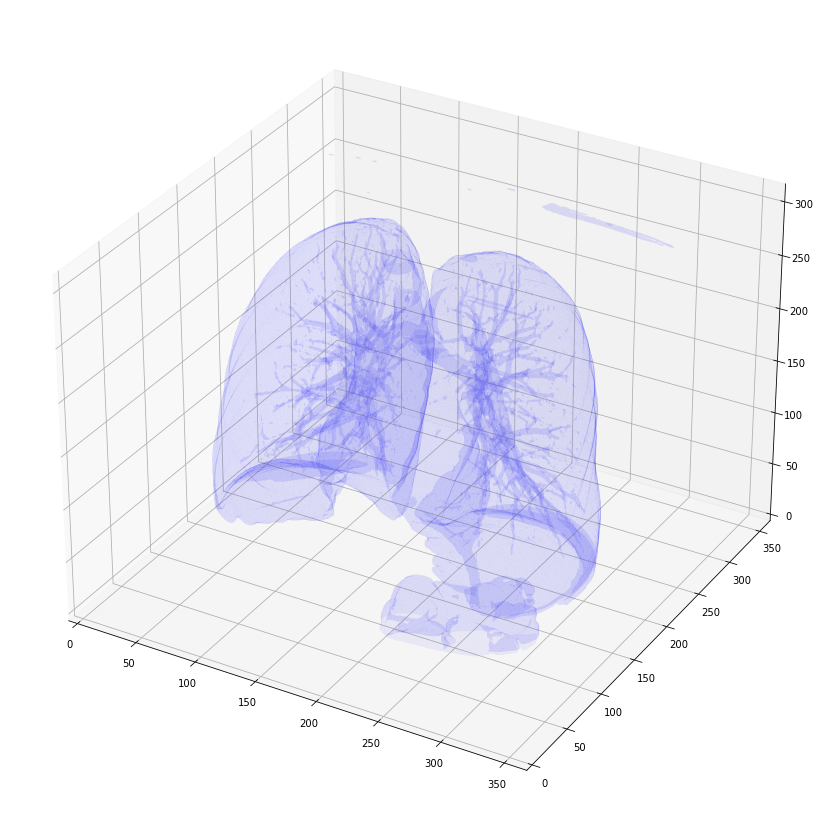

/DATA/jakaria_data/anaconda3/envs/jakaria_tensorflow_1/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: marching_cubes_classic is deprecated in favor of marching_cubes with `method='_lorensen'` to apply Lorensen et al. algorithm. marching_cubes_classic will be removed in version 0.19


ValueError: Surface level must be within volume data range.

In [117]:
from skimage import measure, feature
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, img_mask, threshold= -400):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    # p = p[:,:,::-1]
    
    verts,faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    

    
plot_3d(img2)

In [53]:
unique, counts = np.unique(img2, return_counts=True)

In [54]:
print(unique, counts)

[-3688 -3686 -3652 ...  2715  3003  3196] [1 1 1 ... 1 1 1]


/DATA/jakaria_data/anaconda3/envs/jakaria_tensorflow_1/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: marching_cubes_classic is deprecated in favor of marching_cubes with `method='_lorensen'` to apply Lorensen et al. algorithm. marching_cubes_classic will be removed in version 0.19
  if sys.path[0] == '':


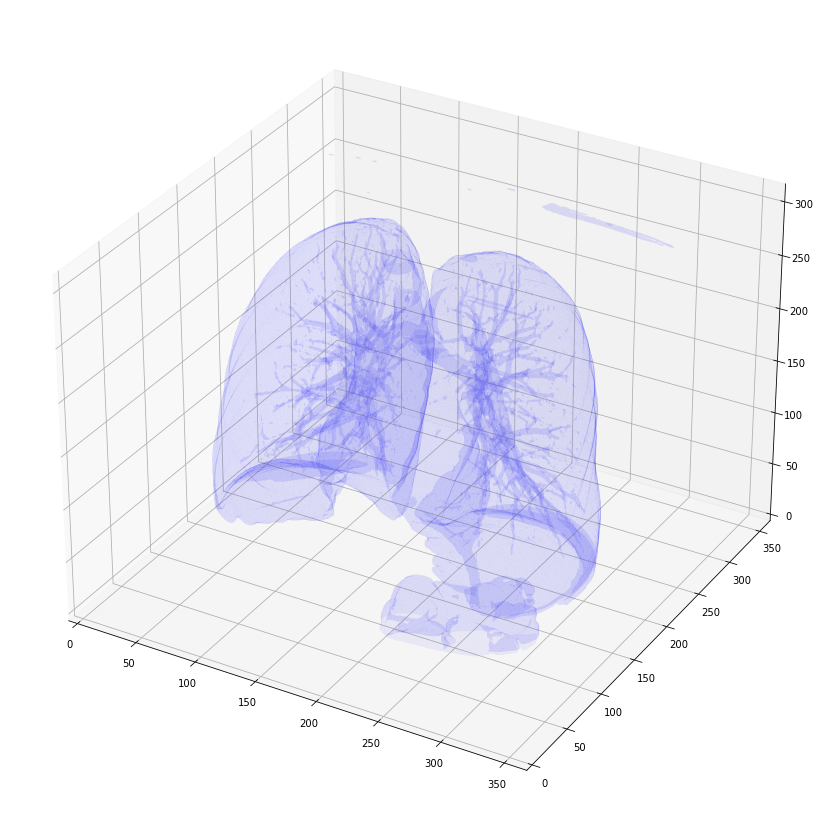

/DATA/jakaria_data/anaconda3/envs/jakaria_tensorflow_1/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: marching_cubes_classic is deprecated in favor of marching_cubes with `method='_lorensen'` to apply Lorensen et al. algorithm. marching_cubes_classic will be removed in version 0.19


ValueError: Surface level must be within volume data range.

In [118]:
from skimage import measure, feature
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, img_mask, threshold= -300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    # p = p[:,:,::-1]
    
    verts,faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
        # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = img_mask.transpose(2,1,0)
    # p = p[:,:,::-1]
    
    verts,faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [1, 0, 0]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
plot_3d(img2,img_mask)

In [129]:
from skimage import measure, feature
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, img_mask, threshold= 100):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    # p = p[:,:,::-1]
    
    verts,faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    #plt.show()
    
        # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = img_mask.transpose(2,1,0)
    # p = p[:,:,::-1]
    
    verts,faces = measure.marching_cubes_classic(p, threshold)

    #fig = plt.figure(figsize=(15, 15))
    #ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.9)
    face_color = [1, 0, 0]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    #ax.set_xlim(0, p.shape[0])
    #ax.set_ylim(0, p.shape[1])
    #ax.set_zlim(0, p.shape[2])

    plt.show()
    
plot_3d(img5,img_mask)

/DATA/jakaria_data/anaconda3/envs/jakaria_tensorflow_1/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: marching_cubes_classic is deprecated in favor of marching_cubes with `method='_lorensen'` to apply Lorensen et al. algorithm. marching_cubes_classic will be removed in version 0.19
  if sys.path[0] == '':
/DATA/jakaria_data/anaconda3/envs/jakaria_tensorflow_1/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: marching_cubes_classic is deprecated in favor of marching_cubes with `method='_lorensen'` to apply Lorensen et al. algorithm. marching_cubes_classic will be removed in version 0.19
